In [1]:
import systole as sy
import pandas as pd
import numpy as np
import glob
import os
import re
import bokeh as bk
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sci
import neurokit2 as nk
from systole.detection import interpolate_clipping, ecg_peaks
from systole.plots import plot_raw
from systole import import_dataset1, import_ppg
from systole import serialSim
from systole.recording import Oximeter

from bokeh.io import output_notebook
from bokeh.plotting import show

In [2]:
#try it for one participant
ppg_folder = "/Users/linaweingartner/Desktop/Bachelor/Data/LinaHorrorData/010"
outfile_exp = "/Users/linaweingartner/Desktop/Bachelor/Data/LinahorrorData/experiment_010.npy"
expinfo = ppg_folder + "/experimentinfo.npy"
outfile_rest = "/Users/linaweingartner/Desktop/Bachelor/Data/LinahorrorData/resting_010.npy"
restinginfo = ppg_folder + "/restinginfo.npy"
os.chdir(ppg_folder)
expfiles = glob.glob("experiment*.npy")
expfiles.remove("experimentinfo.npy")
expfiles.sort(key=lambda s: int(re.search(r'\d+', s).group()))
empty_array = np.empty(shape = (4,0))
for file in expfiles:
    empty_array = np.append(empty_array,np.load(os.path.join(ppg_folder, file)), axis=1)
output = pd.DataFrame(empty_array).T
time = float(np.load(expinfo)[3,0])-60
signals = output.iloc[0].tolist()
columns = len(output)
timestamps = []
i=0
while i < columns:
        timestamps.append(time)
        time = time + 0.0133333333333
        i+=1

print(output)

           0    1            2          3
0      112.0  0.0          NaN   0.000000
1      106.0  0.0          NaN   0.013333
2      101.0  0.0          NaN   0.026667
3       97.0  0.0          NaN   0.040000
4       95.0  0.0          NaN   0.053333
...      ...  ...          ...        ...
99079   34.0  0.0  1173.333333  59.933333
99080   54.0  0.0  1173.333333  59.946667
99081   85.0  0.0  1173.333333  59.960000
99082  125.0  0.0  1173.333333  59.973333
99083  171.0  0.0  1173.333333  59.986667

[99084 rows x 4 columns]


In [273]:
print(time)

1700645315.8591902


In [3]:
participants = ["010","015","016","017","018","019","023","024","025","045","311","317","320","323","333","337","338","342","348","350","351"]
#dictionary for where starttimes are missing
starttimes = {
    "015":1700738542.0,
    "337":1701337632.0,
    "016":1701347614.0,
    "045":1700644786.0
}
for participant in participants:
    ppg_folder = "/Users/linaweingartner/Desktop/Bachelor/Data/LinaHorrorData/" + participant 
    #restinginfo = ppg_folder + "/restinginfo.npy"
    os.chdir(ppg_folder)
    expfiles = glob.glob("experiment*.npy")
    if "experimentinfo.npy" in expfiles:
        expfiles.remove("experimentinfo.npy")
    expfiles.sort(key=lambda s: int(re.search(r'\d+', s).group()))
    empty_array = np.empty(shape = (4,0))
    firstfile = np.load(expfiles[0])
    timediff = max(firstfile[3])
    for file in expfiles:
        empty_array = np.append(empty_array,np.load(os.path.join(ppg_folder, file)), axis=1)
    #output = pd.DataFrame(empty_array).T
    if participant in ["015","016","337","045"]:
        time = float(starttimes[participant])-timediff
    else: time = float(np.load("experimentinfo.npy")[3,0])-timediff
    #signals = output.iloc[0].tolist()
    columns = len(empty_array[0])
    timestamps = [[]]
    i=0
    while i < columns:
        timestamps[0].append(time)
        time = time + 0.0133333
        i+=1
    array = np.append(empty_array, timestamps, axis = 0)
    exp = pd.DataFrame(array).T
    timestamp_path = "/Users/linaweingartner/Desktop/Bachelor/Data/HorrorStudyData/" + participant + "/" + participant + "_jumpscareTiming.csv"
    timestamp_df = pd.read_csv(timestamp_path, header = None, dtype = 'Float64')
    timestamp = timestamp_df.iat[0,0]
    experiment_seq = exp[(exp.iloc[:,4] > (timestamp - 180000))& (exp.iloc[:,4] < timestamp)]
    restingfiles = glob.glob("resting*.npy")
    if "restinginfo.npy" in restingfiles:
        restingfiles.remove("restinginfo.npy")
    restingfiles.sort(key=lambda s: int(re.search(r'\d+', s).group()))
    empty_array2 = np.empty(shape = (4,0))
    for file in restingfiles:
        empty_array2 = np.append(empty_array2, np.load(os.path.join(ppg_folder, file)), axis=1)
    #array2 = empty_array2
    rest = pd.DataFrame(empty_array2).T
    #exp.to_csv("experimentfull_ppg.csv")
    #rest.to_csv("resting_ppg.csv")

In [32]:
print(timediff)

60.986666666666665


In [214]:
#try cardiac analysis for one person
df = pd.read_csv("/Users/linaweingartner/Desktop/Bachelor/Data/LinaHorrorData/342/experiment_ppg.csv")
df.columns = ["0","PPG_Signal", "Peaks", "Threshold", "Timestamp_Seconds", "Timestamp_Unix"]
#cutting down the time to only include the 3 minutes before the jumpscare
timestamp_path = "/Users/linaweingartner/Desktop/Bachelor/Data/HorrorStudyData/342/342_jumpscareTiming.csv"
timestamp_df = pd.read_csv(timestamp_path, header = None, dtype = 'Float64')
timestamp = timestamp_df.iat[0,0]/1000
df_timefiltered = df[(df["Timestamp_Unix"] > (timestamp - 60))& (df["Timestamp_Unix"] < timestamp+60)]
ppg = df_timefiltered["PPG_Signal"]#.to_list()
bk.plotting.show(sy.plot_raw(ppg, modality='ppg', sfreq=75, backend='bokeh', show_heart_rate=True))

In [190]:
signal = ppg.to_numpy()  # Extract a portion of signal with clipping artefacts
clean_signal = sy.interpolate_clipping(signal, min_threshold=0, max_threshold=255)  # Remove clipping segment and interpolate missing calues
signal, peaks = sy.ppg_peaks(signal=signal, sfreq=1000)
#should i resample or no?
# Convert peaks vector to RR time series
rr = sy.input_conversion(peaks, input_type='peaks', output_type='rr_ms')
#plot irregular values/potential artefacts
bk.plotting.show(
    sy.plot_subspaces(rr, input_type='rr_ms', backend='bokeh', figsize=400)
)

In [ ]:
#artefact detection
#correct_rr for longer recordings, produces very clean data at the expense of timing, corrects in the time-series
corrected_rr, _ = sy.correct_rr(rr)
#correct_peaks for shorter recordings where timing is more essential, corrects in the peaks vector
peaks_correction = sy.correct_peaks(peaks)

In [295]:
#now do it for all participants
#for the baseline recording
listoflists = []
for participant in participants:
    df = pd.read_csv("/Users/linaweingartner/Desktop/Bachelor/Data/LinaHorrorData/" + participant + "/resting_ppg.csv")
    df.columns = ["0","PPG_Signal", "Peaks", "Threshold", "Timestamp_Seconds"]
    ppg = df["PPG_Signal"]
    #peaks = sy.ppg_peaks(ppg,75)
    #bk.plotting.show(sy.plot_raw(ppg, modality='ppg', sfreq=75, backend='bokeh', show_heart_rate=True))
    signal = ppg.to_numpy()
    signal, peaks = sy.ppg_peaks(signal=signal, sfreq = 75)
    #should i resample or no?
    # Convert peaks vector to RR time series
    rr = sy.input_conversion(peaks, input_type='peaks', output_type='rr_ms', sfreq = 1000)
    #plot irregular values/potential artefacts
    # bk.plotting.show(sy.plot_subspaces(rr, input_type='rr_ms', backend='bokeh', figsize=400)) 
    #selecting participants with irregular valuesfor correction
    if participant in ["338", "337", "333", "045", "019", "010"]:
        #using sy.correct_rr() instead of sy.correct_peaks() as the baseline recording is not timing sensitive
        #bk.plotting.show(plot_raw(signal, backend='bokeh', show_artefacts=True, show_heart_rate=True, figsize=300))
        rr, _ = sy.correct_rr(rr)
        #bk.plotting.show(sy.plot_rr(corrected_rr, input_type='rr_ms', backend="bokeh", show_artefacts=True,line=False, figsize=300))
        # Extract time domain heart rate variability
    hrv_time = sy.time_domain(rr, input_type='rr_ms')
    hrv_freq = sy.frequency_domain(rr, input_type='rr_ms')
    hrv_nonlin = sy.nonlinear_domain(rr, input_type='rr_ms')
    hrv_data = pd.concat([hrv_time, hrv_freq, hrv_nonlin]).T
    values = hrv_data.iloc[0].to_list()
    header1 = hrv_data.iloc[1].to_list()
    string = '_resting'
    header = [x + string for x in header1]
    listoflists.append(values)
baseline_data = pd.DataFrame(listoflists, columns = header)
baseline_data.insert(0,"ParticipantID",participants)
baseline_data.to_csv("heartrate_baseline.csv")


Cleaning the RR interval time series.
... correcting 1 short interval(s).
... correcting 1 long interval(s).
Cleaning the RR interval time series.
... correcting 4 ectopic interval(s).
Cleaning the RR interval time series.
... correcting 2 missed interval(s).
... correcting 2 extra interval(s).
... correcting 3 short interval(s).
Cleaning the RR interval time series.
Cleaning the RR interval time series.
... correcting 1 long interval(s).
Cleaning the RR interval time series.
... correcting 1 extra interval(s).
... correcting 1 ectopic interval(s).
... correcting 1 short interval(s).


In [5]:
#for the segment during the n-back task
listoflists = []
for participant in participants:
    df = pd.read_csv("/Users/linaweingartner/Desktop/Bachelor/Data/LinaHorrorData/" + participant + "/experimentfull_ppg.csv")
    df.columns = ["0","PPG_Signal", "Peaks", "Threshold", "Timestamp_Seconds", "Timestamp_Unix"]
    #cutting down the time to only include the 3 minutes before the jumpscare
    timestamp_path = "/Users/linaweingartner/Desktop/Bachelor/Data/HorrorStudyData/" + participant + "/" + participant + "_jumpscareTiming.csv"
    timestamp_df = pd.read_csv(timestamp_path, header = None, dtype = 'Float64')
    if participant == "024":
        timestamp = 1700491390.476033
    else:
        timestamp = timestamp_df.iat[0,0]/1000
    df_timefiltered = df[(df["Timestamp_Unix"] > (timestamp - 180))& (df["Timestamp_Unix"] < timestamp-1)]
    ppg = df_timefiltered["PPG_Signal"]
    #bk.plotting.show(sy.plot_raw(ppg, modality='ppg', sfreq=75, backend='bokeh', show_heart_rate=True))
    signal = ppg.to_numpy()
    signal, peaks = sy.ppg_peaks(signal=signal, sfreq=75)
    #should i resample or no?
    # Convert peaks vector to RR time series
    rr = sy.input_conversion(peaks, input_type='peaks', output_type='rr_ms', sfreq = 1000)
    #plot irregular values/potential artefacts
    # bk.plotting.show(
    # sy.plot_subspaces(rr, input_type='rr_ms', backend='bokeh', figsize=400)
    # ) 
    corrected_rr, _ = sy.correct_rr(rr)
    #bk.plotting.show(sy.plot_rr(corrected_rr, input_type='rr_ms', backend="bokeh", show_artefacts=True,line=False, figsize=300))
    hrv_time = sy.time_domain(corrected_rr, input_type='rr_ms')
    hrv_freq = sy.frequency_domain(corrected_rr, input_type='rr_ms')
    hrv_nonlin = sy.nonlinear_domain(corrected_rr, input_type='rr_ms')
    hrv_data = pd.concat([hrv_time, hrv_freq, hrv_nonlin]).T
    values = hrv_data.iloc[0].to_list()
    header1 = hrv_data.iloc[1].to_list()
    string = '_task'
    header = [x + string for x in header1]
    listoflists.append(values)
task_data = pd.DataFrame(listoflists, columns = header)
task_data.insert(0,"ParticipantID",participants)
task_data.to_csv("/Users/linaweingartner/Desktop/Bachelor/Data/heartrarte_task_new.csv")

Cleaning the RR interval time series.
... correcting 1 long interval(s).
Cleaning the RR interval time series.
... correcting 2 long interval(s).
Cleaning the RR interval time series.
... correcting 3 missed interval(s).
... correcting 10 ectopic interval(s).
Cleaning the RR interval time series.
... correcting 2 extra interval(s).
... correcting 6 ectopic interval(s).
... correcting 2 short interval(s).
... correcting 3 long interval(s).
Cleaning the RR interval time series.
Cleaning the RR interval time series.
... correcting 1 extra interval(s).
... correcting 3 ectopic interval(s).
... correcting 1 short interval(s).
... correcting 1 long interval(s).
Cleaning the RR interval time series.
Cleaning the RR interval time series.
... correcting 5 ectopic interval(s).
Cleaning the RR interval time series.
... correcting 1 ectopic interval(s).
... correcting 1 short interval(s).
... correcting 1 long interval(s).
Cleaning the RR interval time series.
... correcting 1 extra interval(s).
.

Cleaning the peaks vector using 1 iterations.
 - Iteration 1 - 
... correcting 1 extra peak(s).
... correcting 10 missed peak(s).
{'Peaks': array([  561,  1236,  2055,  2646,  3552,  3952,  4611,  5726,  6637,
        7058,  7746,  8348,  8893,  9707, 10239, 10669, 11374, 12441,
       13099, 13843, 14158, 14652, 15095, 15907, 16063, 16745, 17541,
       18155]), 'Distance': array([614., 675., 682., 156., 812., 400., 494., 315., 744., 421., 688.,
       602., 430., 532., 532., 430., 602., 688., 421., 744., 315., 494.,
       400., 812., 156., 682., 675., 614.]), 'Height': array([2.04265570e+01, 1.50966993e+01, 1.07314478e+00, 1.39937069e+01,
       7.46379280e+00, 2.28930455e+00, 2.52273354e+01, 2.09863951e+01,
       2.04883931e+00, 1.09136836e+01, 2.25270050e+01, 5.64210016e+00,
       1.40224688e+01, 1.13049183e+01, 8.04075628e+00, 3.94785948e-01,
       9.54678896e+00, 4.73498644e+00, 3.29929749e+01, 1.22001606e+01,
       3.72696707e-01, 1.93794729e+00, 6.85948723e+00, 2.59896152e

/var/folders/gf/rkyn3m311dngzpwqgn_tkmw00000gn/T/ipykernel_3145/1640955946.py:60: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  _, ax = plt.subplots(figsize=(13, 5))


{'Peaks': array([  538,  1062,  1703,  2463,  2865,  3518,  4185,  4848,  5407,
        6340,  7016,  7889,  8542,  9279,  9820, 10441, 11104, 11759,
       12262, 12882, 13741, 14218, 14583, 15599, 16205, 16755, 17307,
       17758, 18398]), 'Distance': array([640., 451., 552., 550., 402., 653., 365., 477., 559., 620., 503.,
       655., 653., 621., 541., 621., 653., 655., 503., 620., 559., 477.,
       365., 653., 402., 550., 552., 451., 640.]), 'Height': array([1.87870700e+01, 5.48325738e+01, 2.73447786e+01, 3.85481529e+01,
       3.99295127e-01, 3.15669069e+01, 2.46295410e+01, 4.89251356e+00,
       3.71551032e+01, 2.53953454e+01, 6.16355253e+01, 2.87730815e+01,
       4.96945792e+00, 3.73623159e+01, 4.21487602e+01, 1.21862462e+01,
       2.60584238e+01, 1.13300463e+01, 4.04248311e+01, 3.92409081e+01,
       1.22237604e+01, 2.71568868e+01, 1.57814328e-02, 5.54495216e+01,
       5.44770407e+01, 3.57989334e+01, 1.47307231e+01, 7.49629667e+00,
       1.40207783e+00]), 'Width': array([

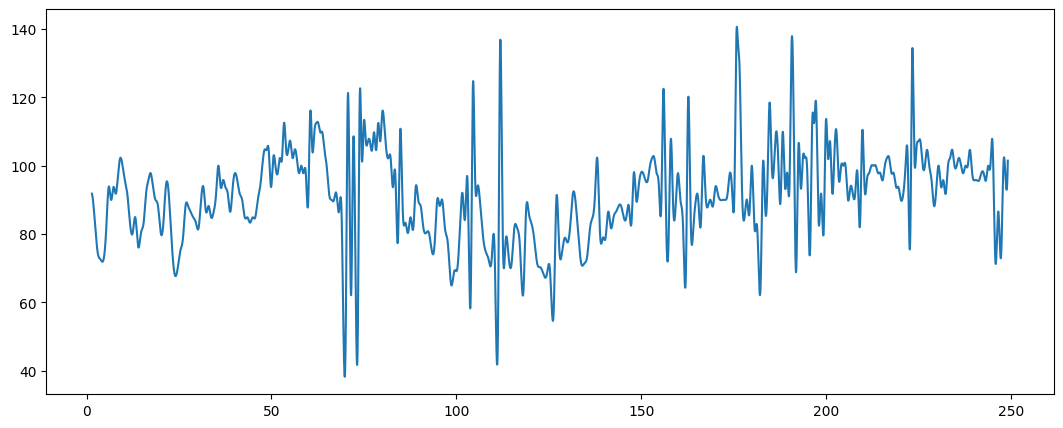

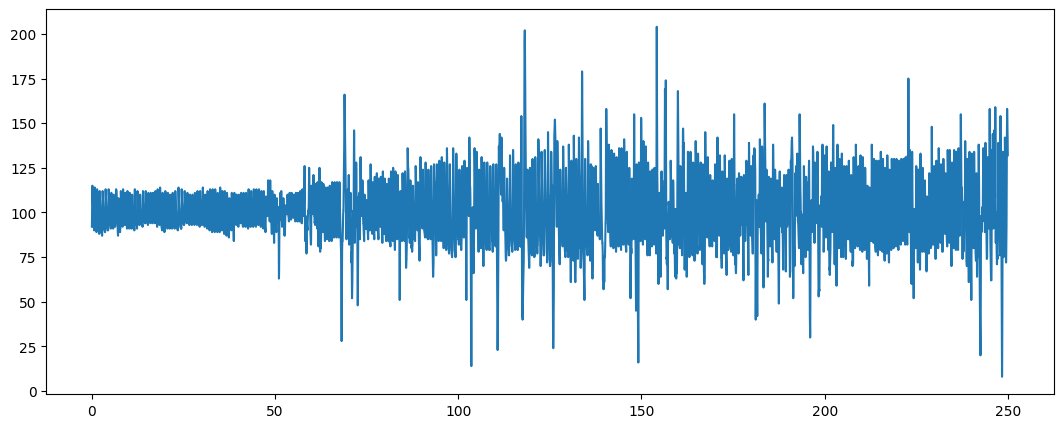

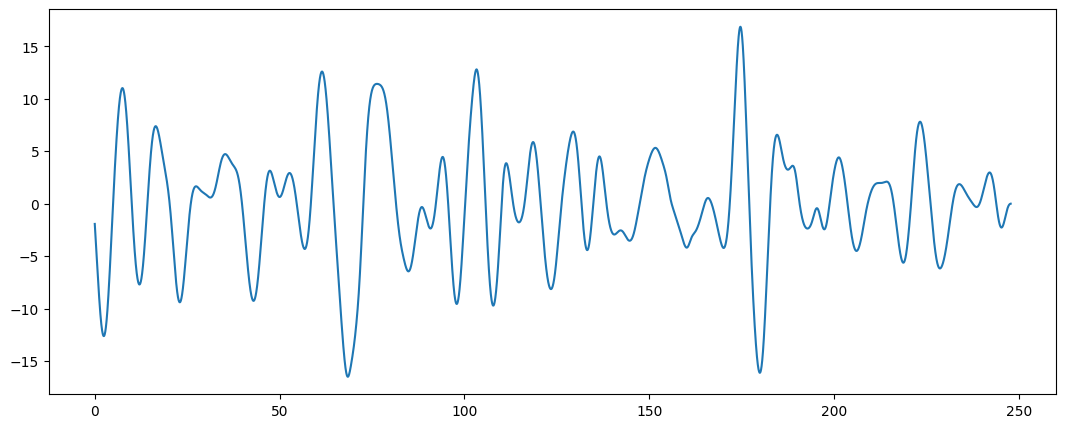

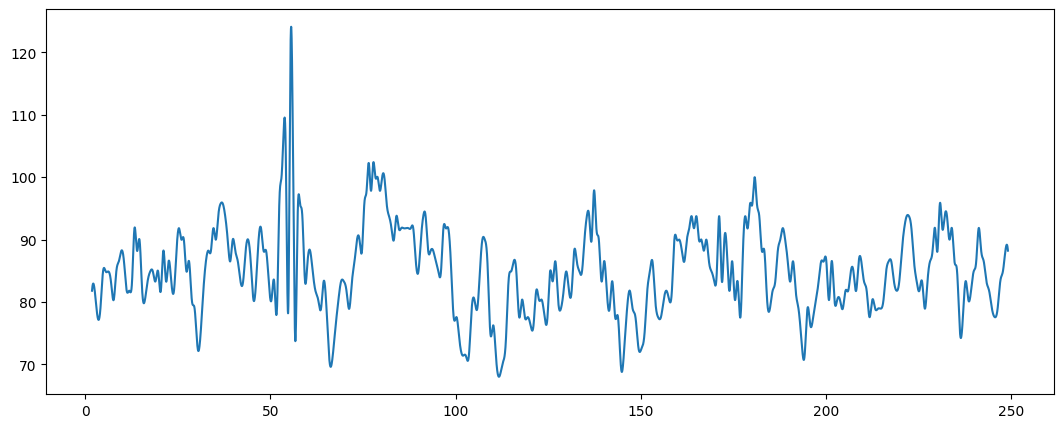

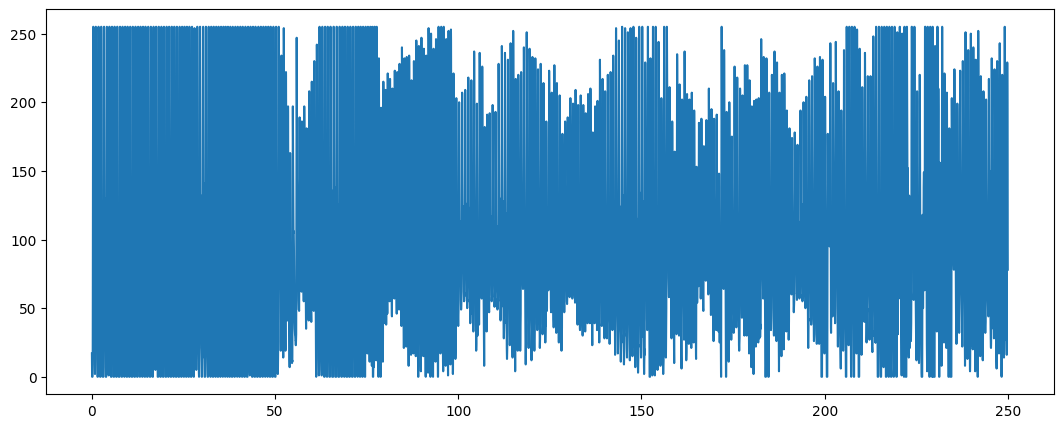

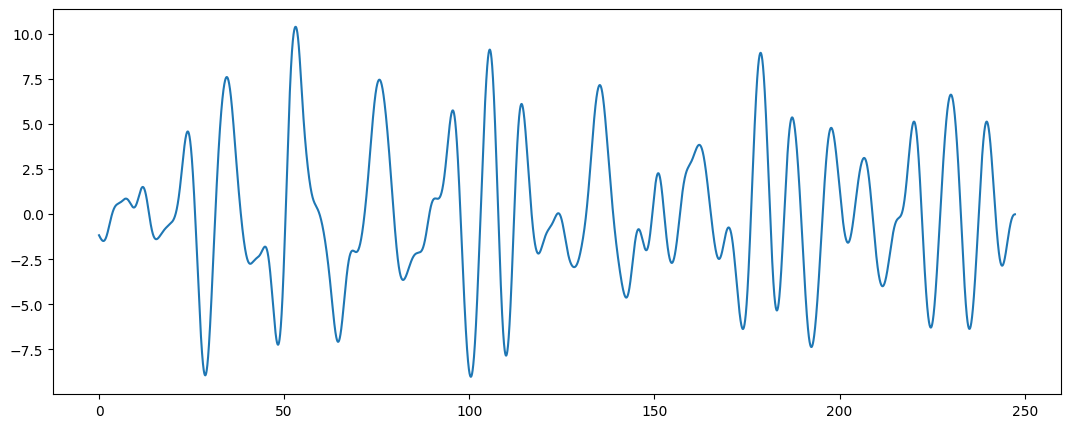

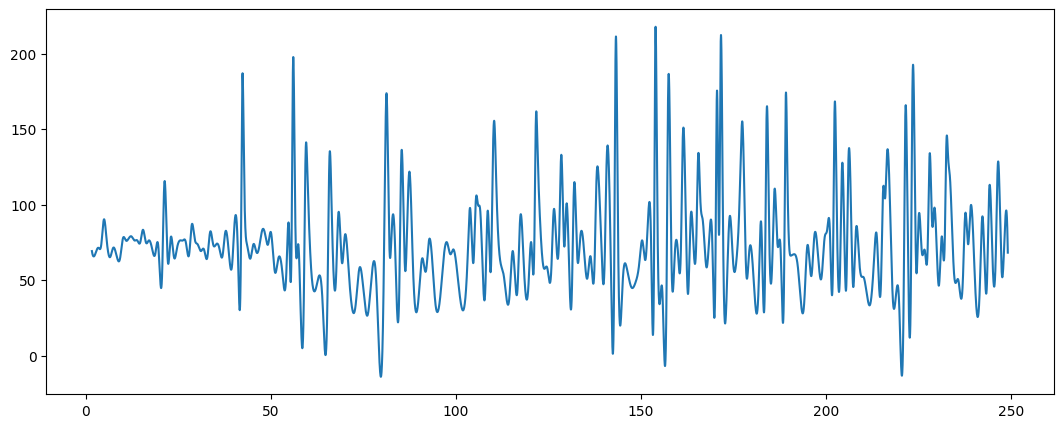

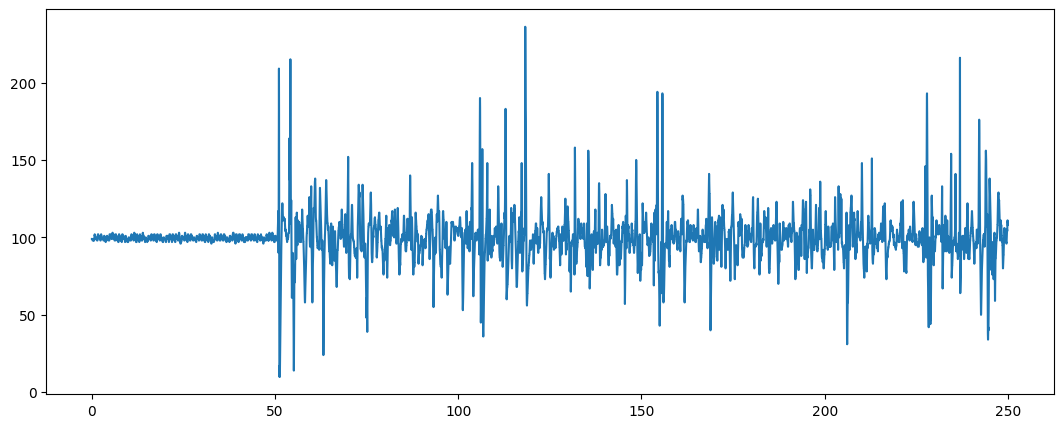

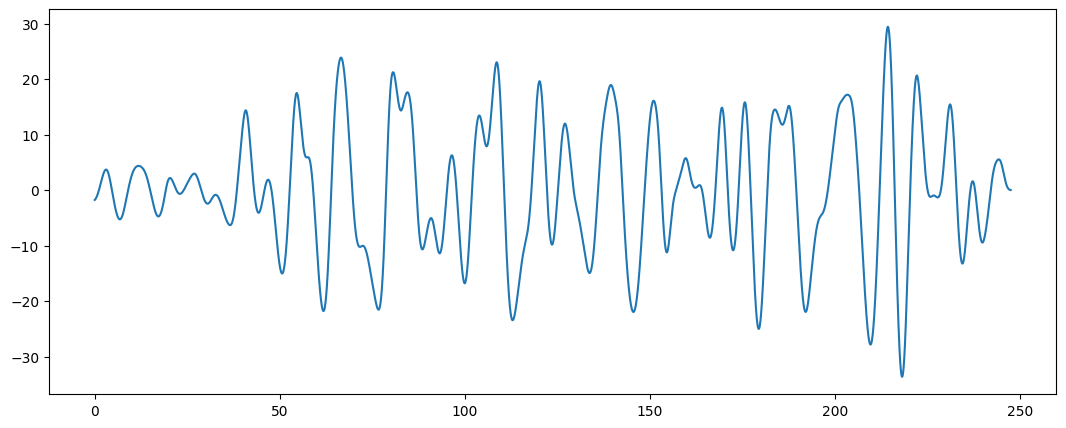

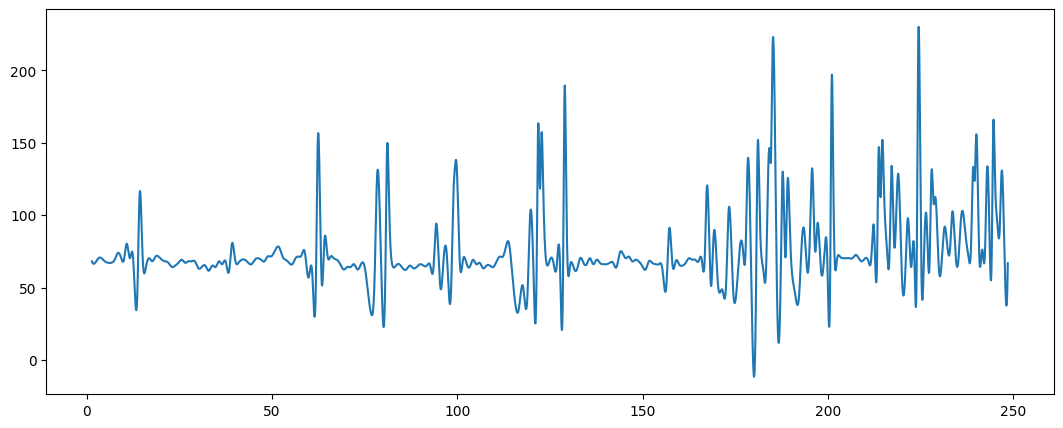

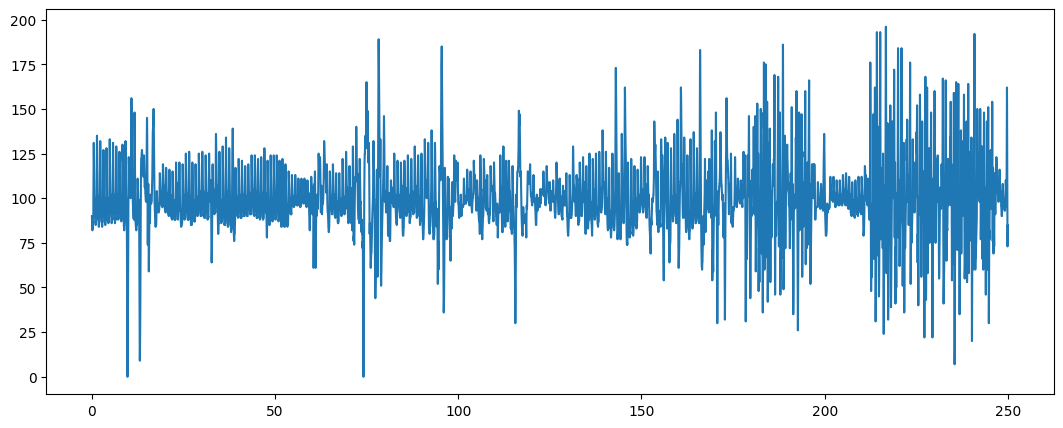

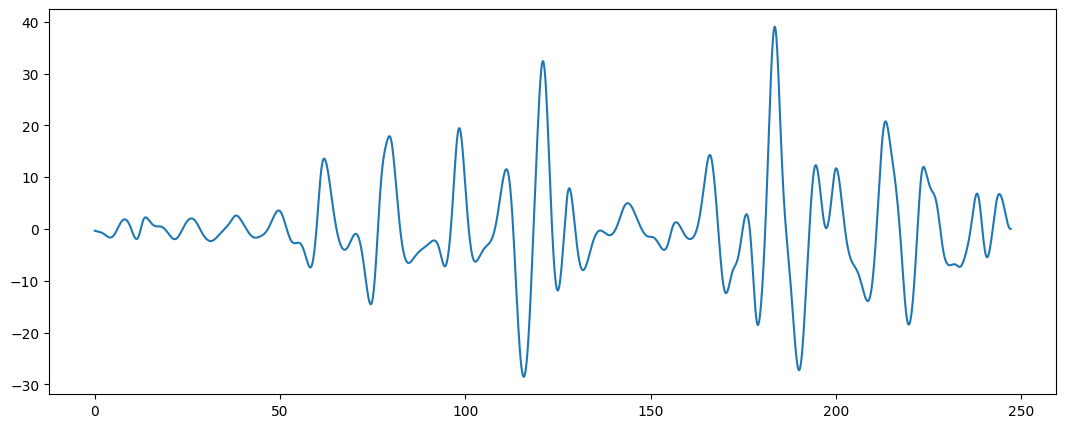

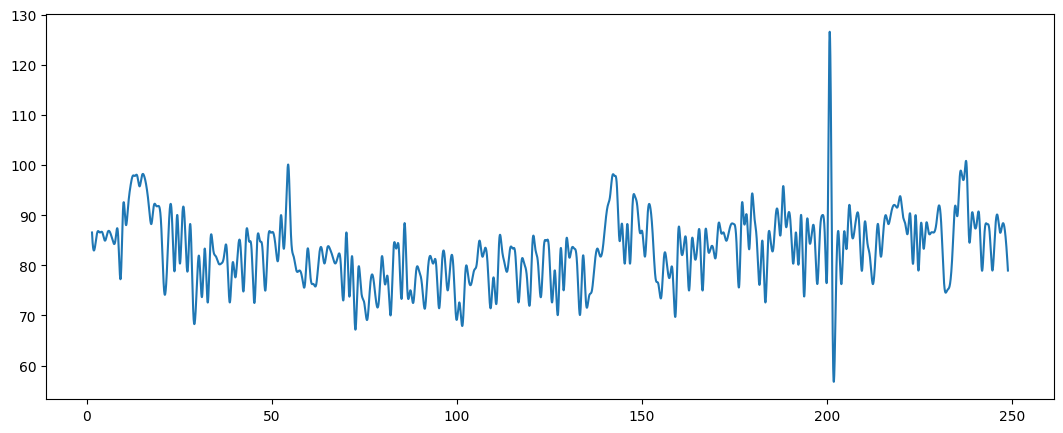

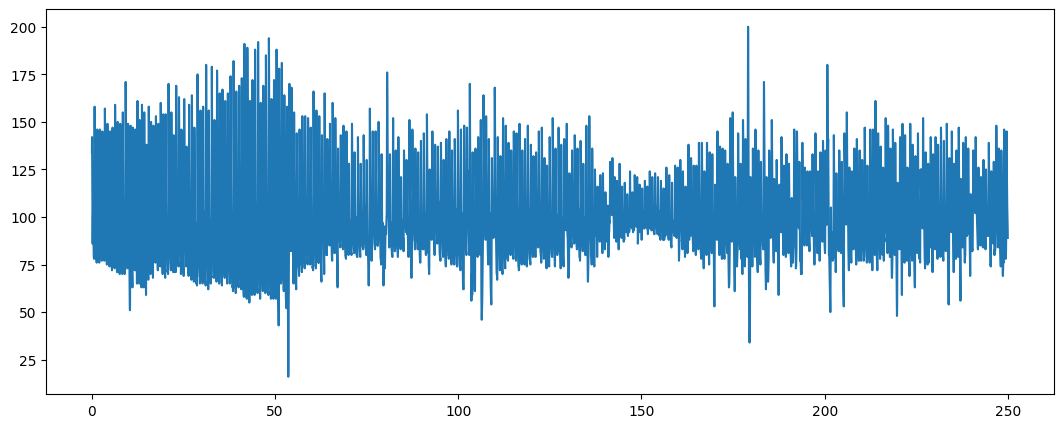

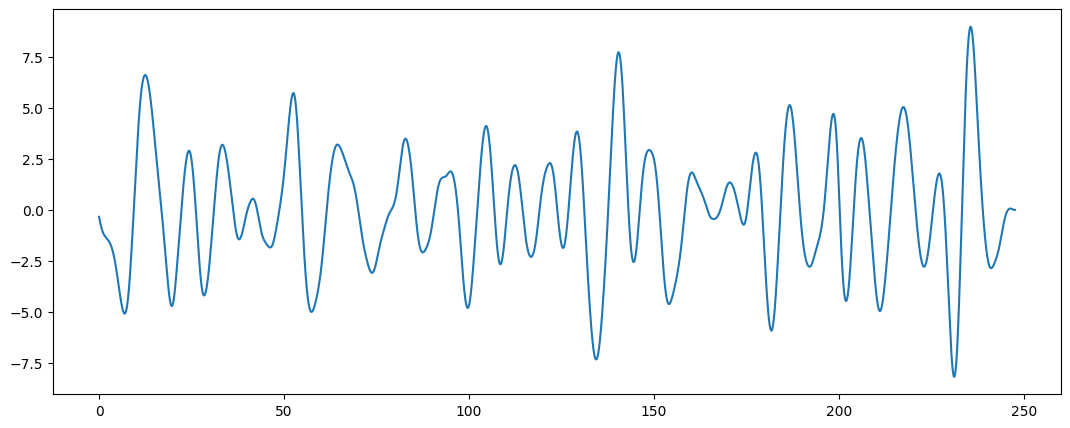

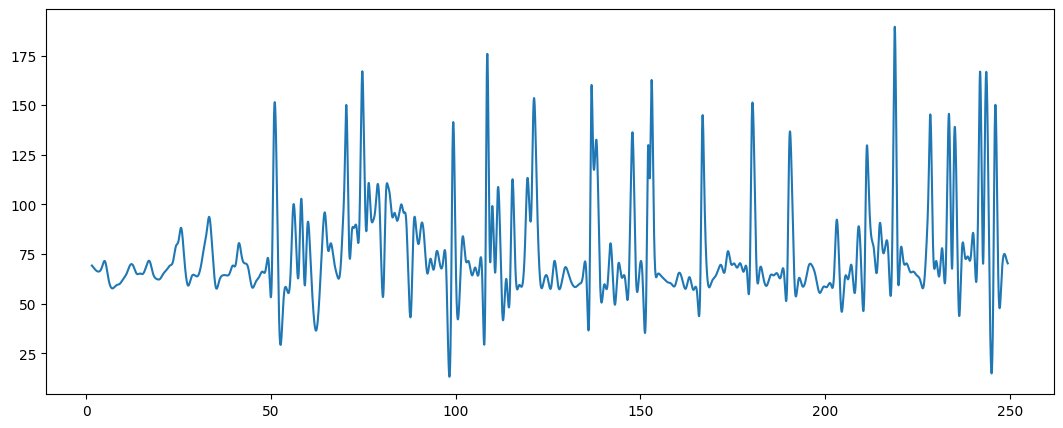

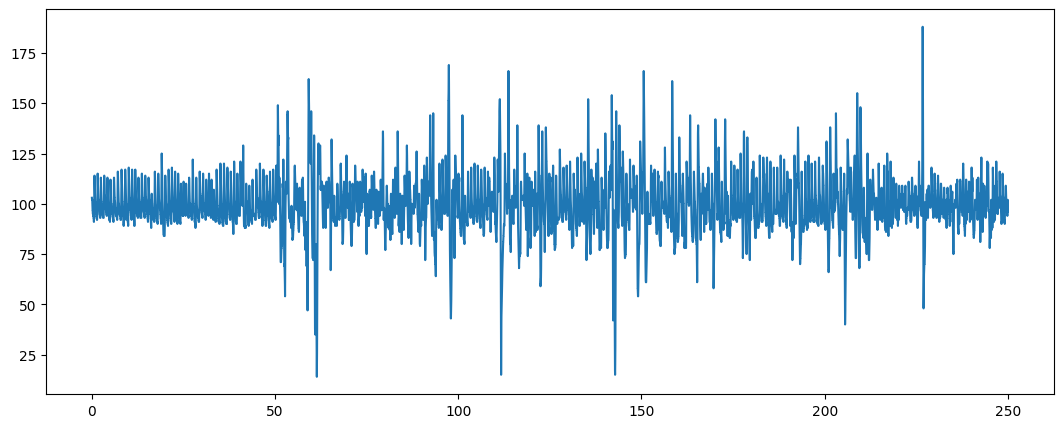

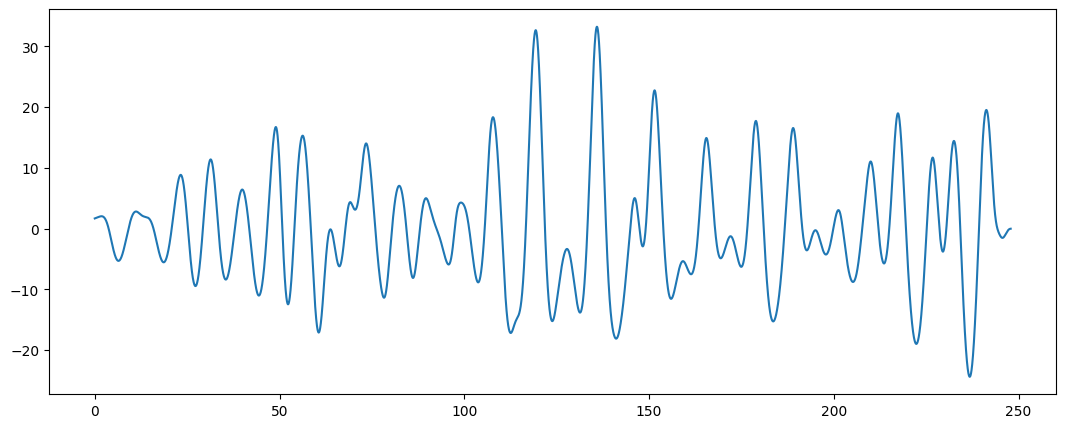

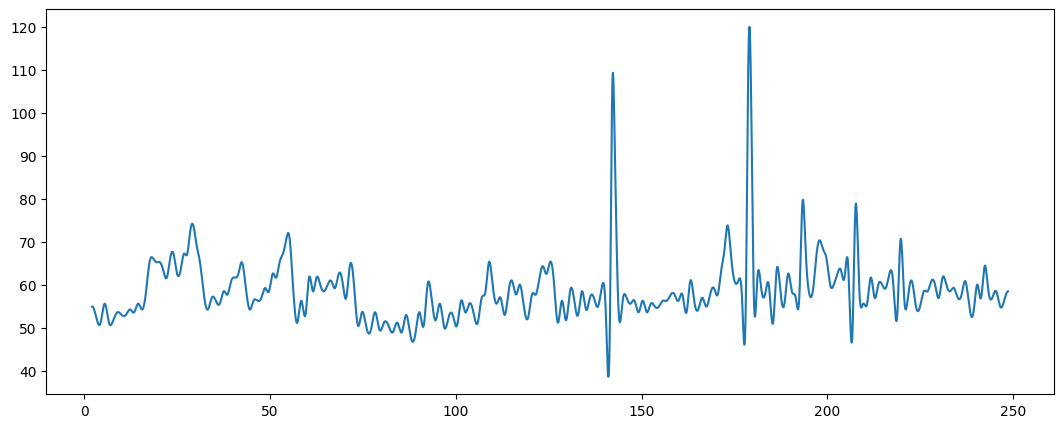

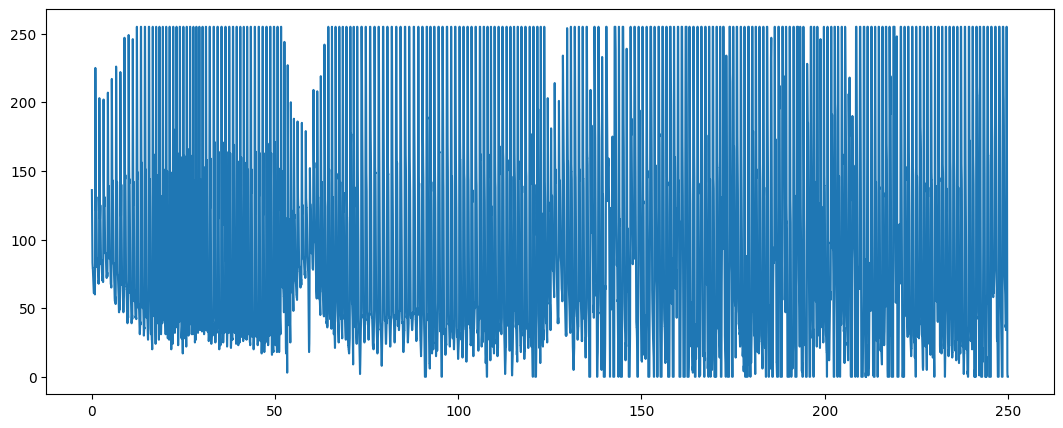

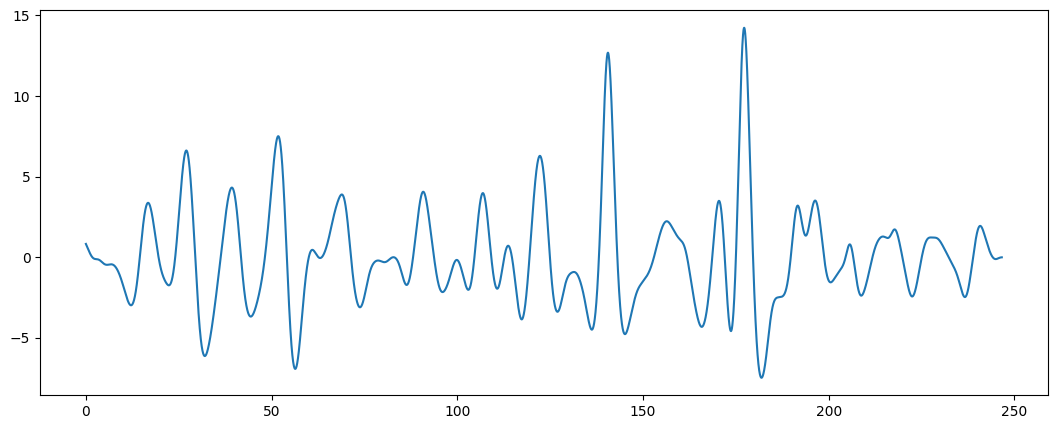

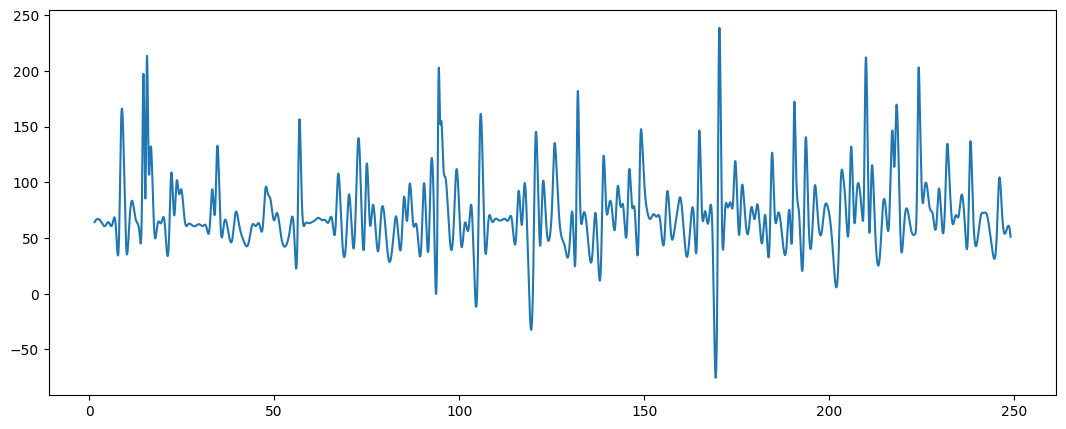

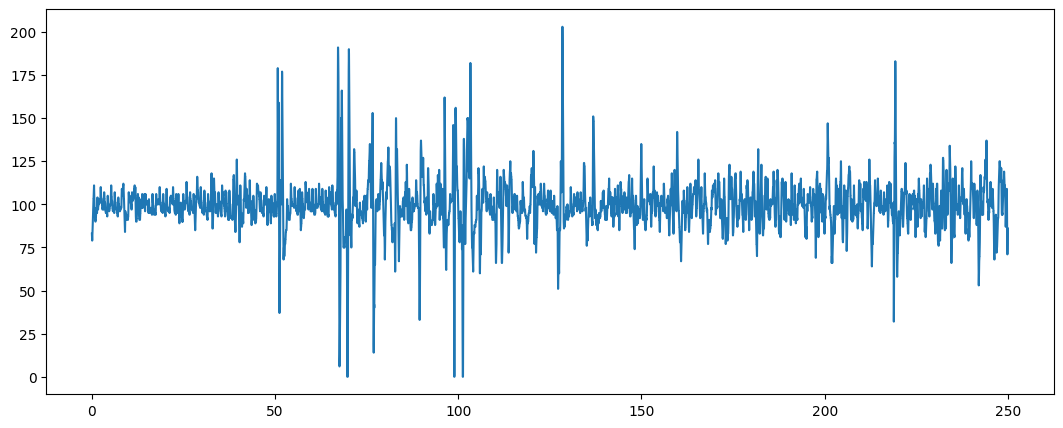

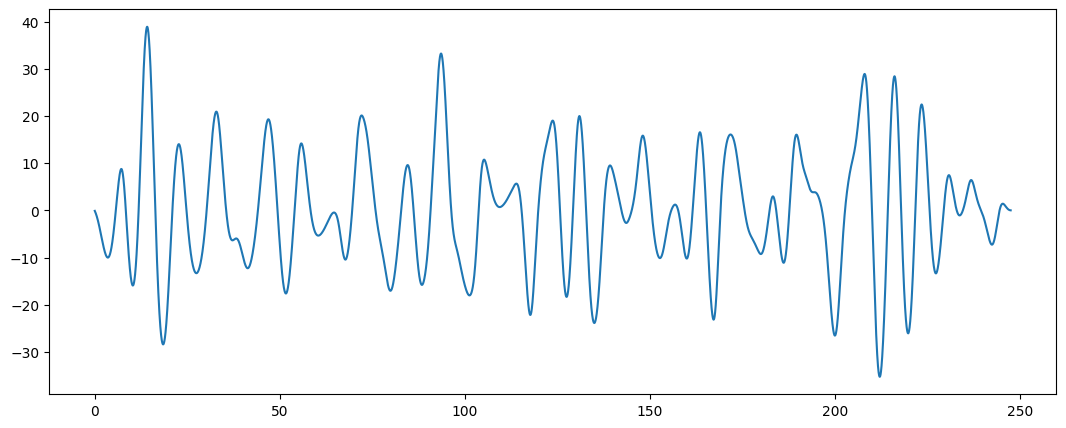

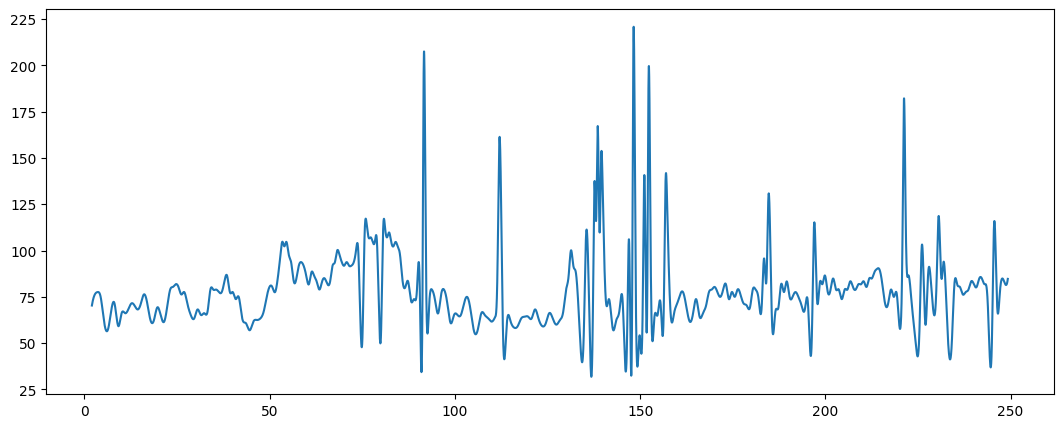

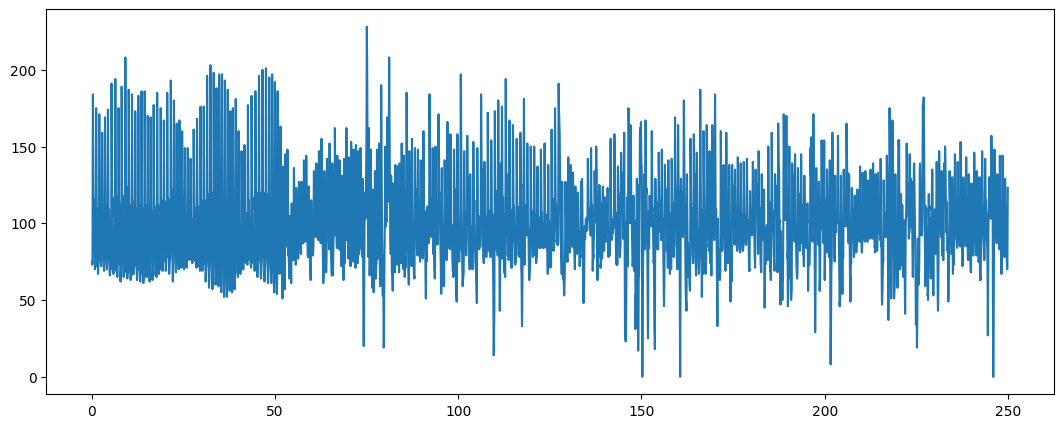

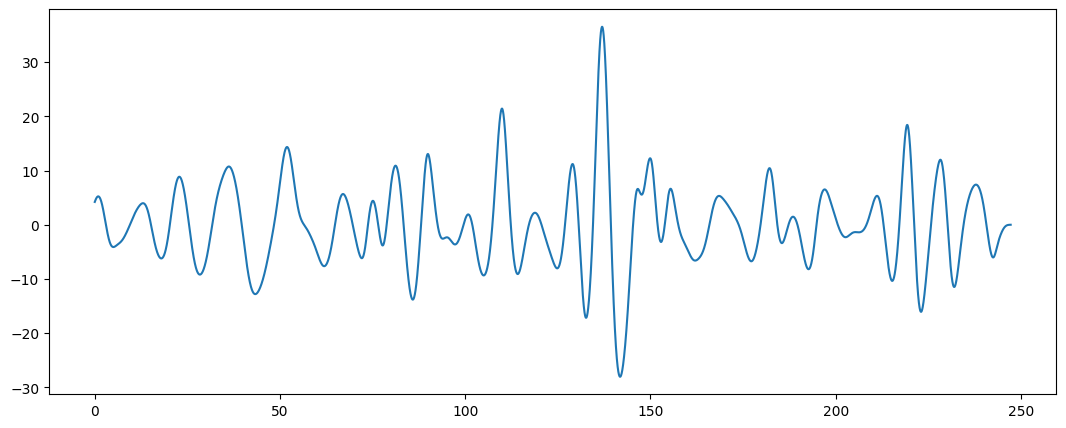

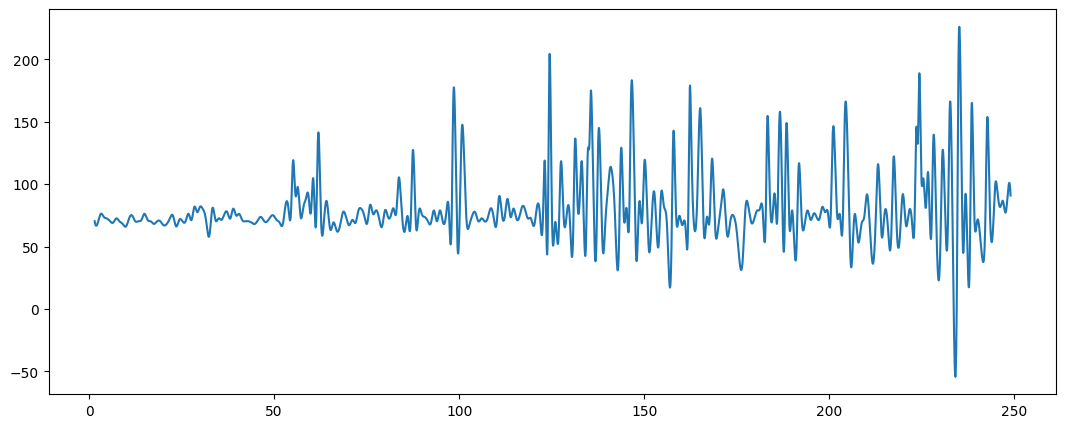

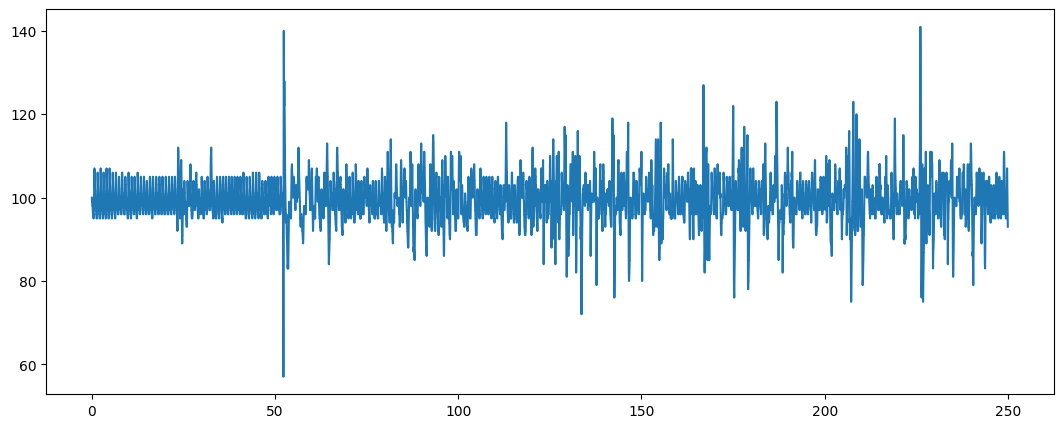

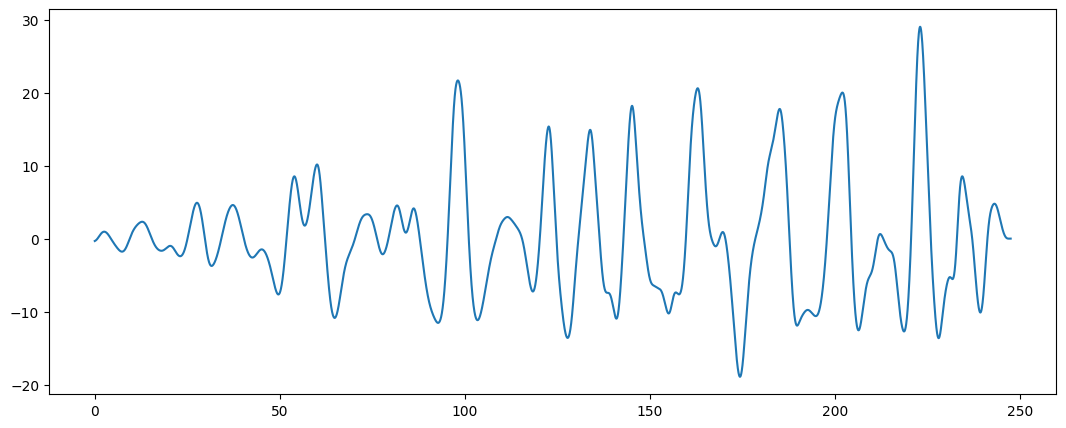

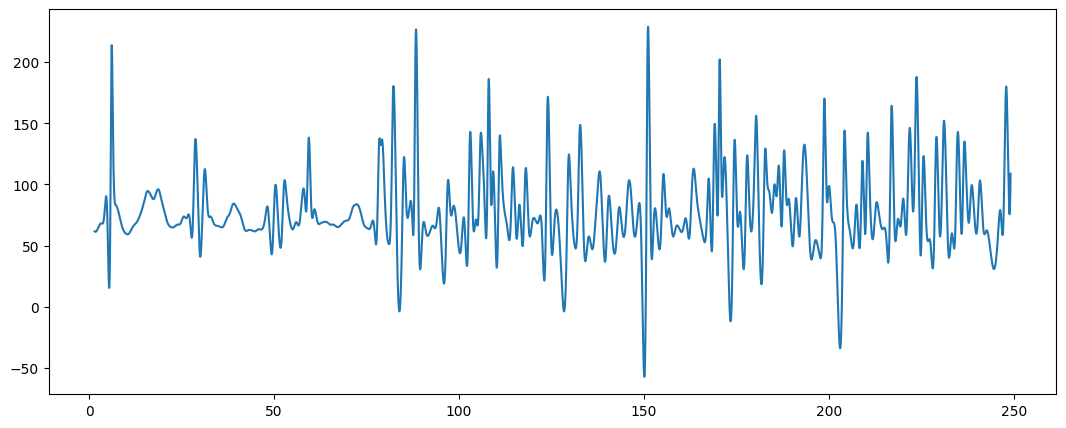

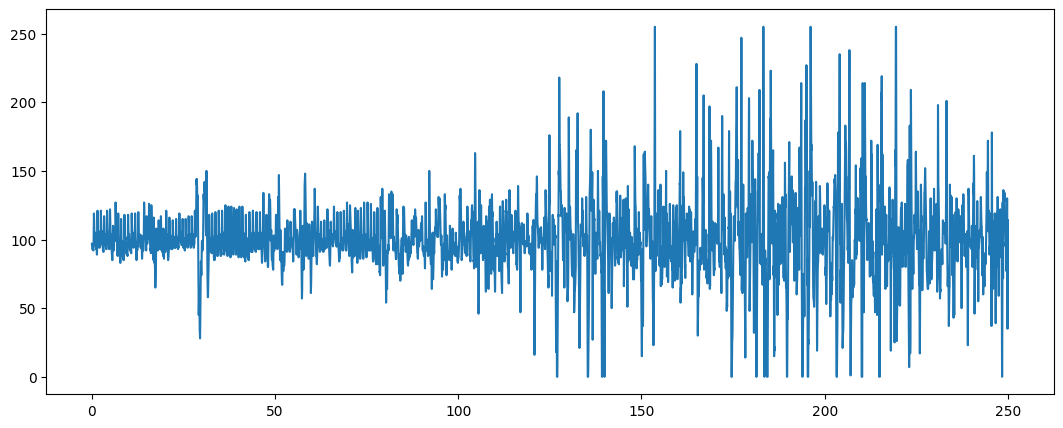

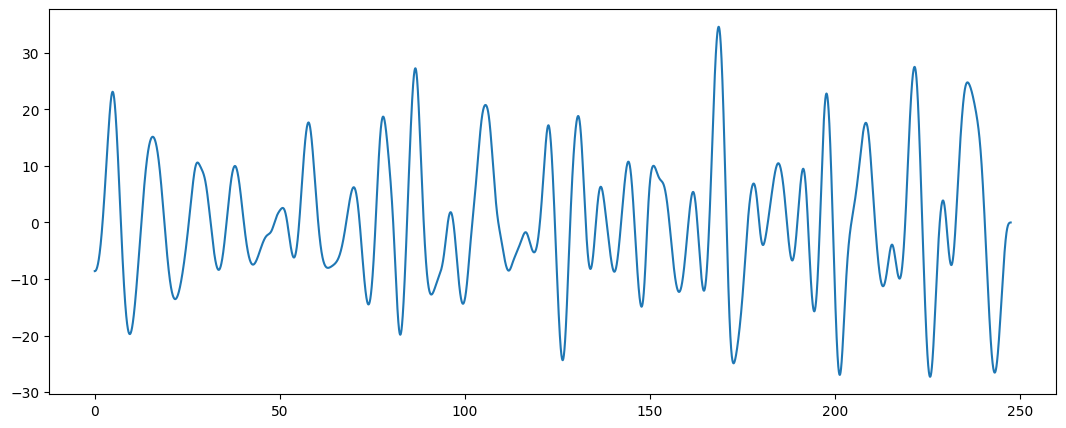

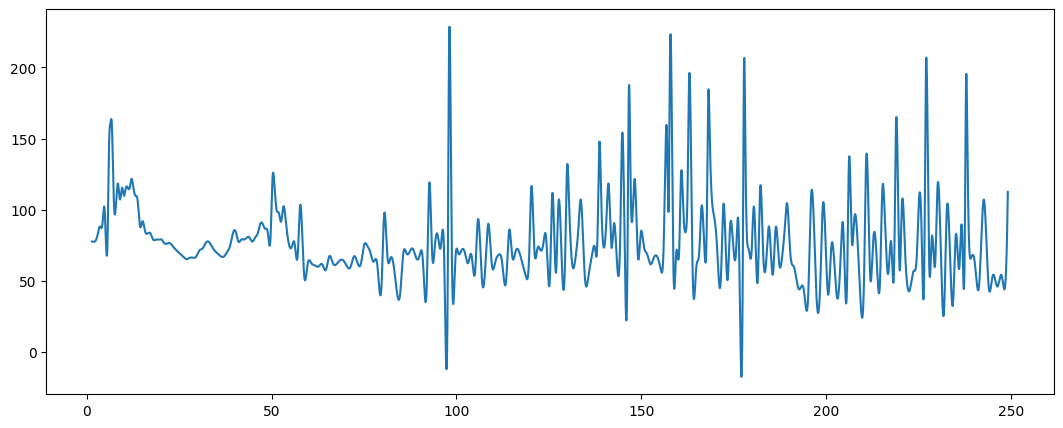

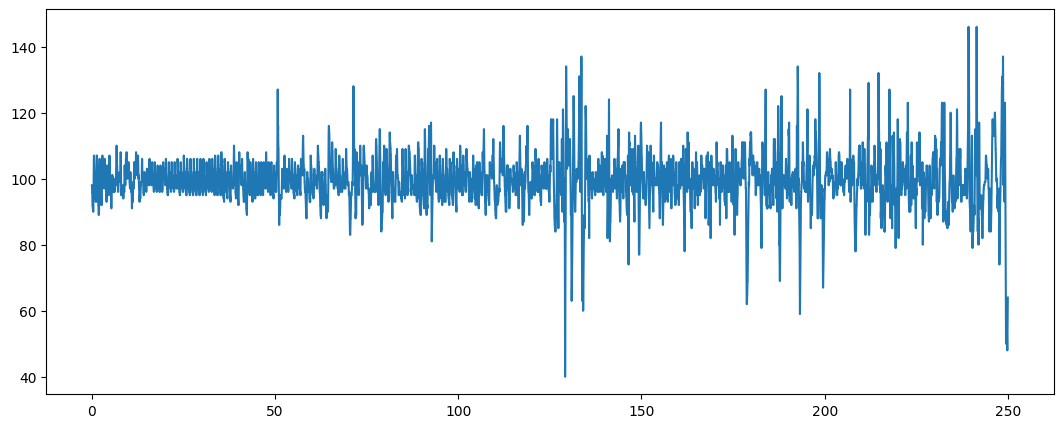

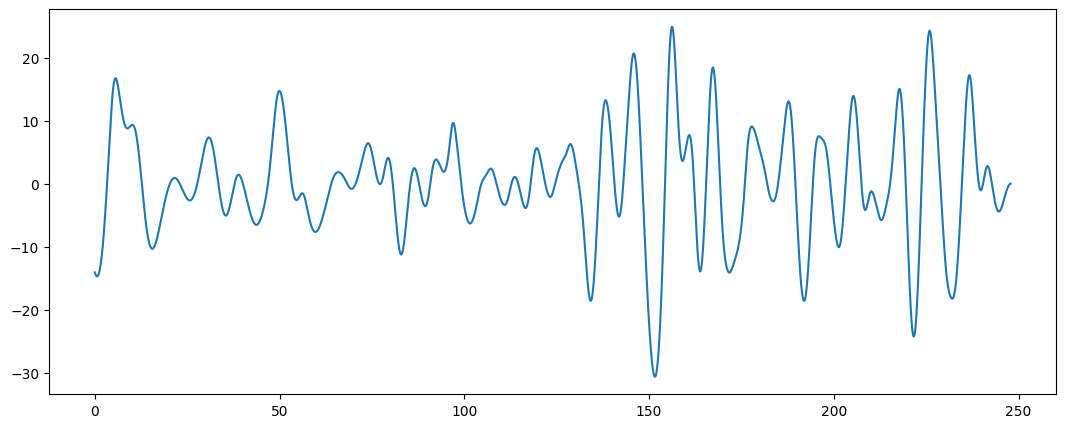

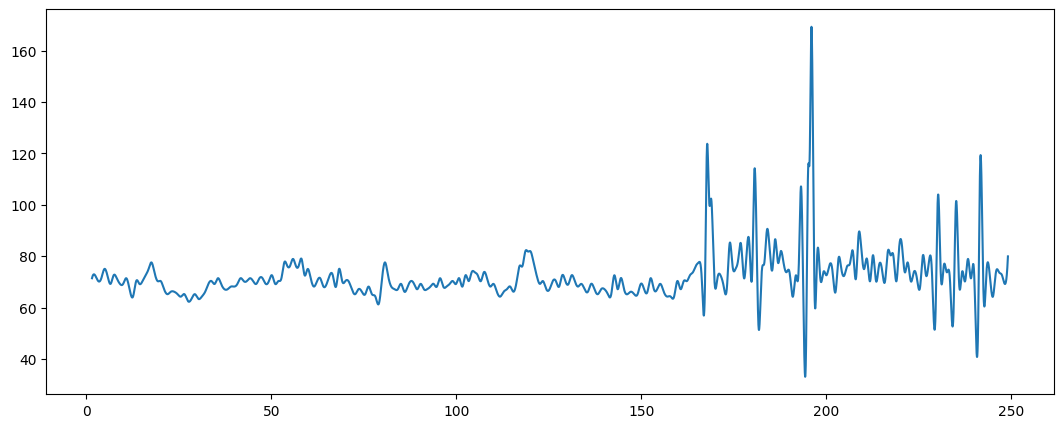

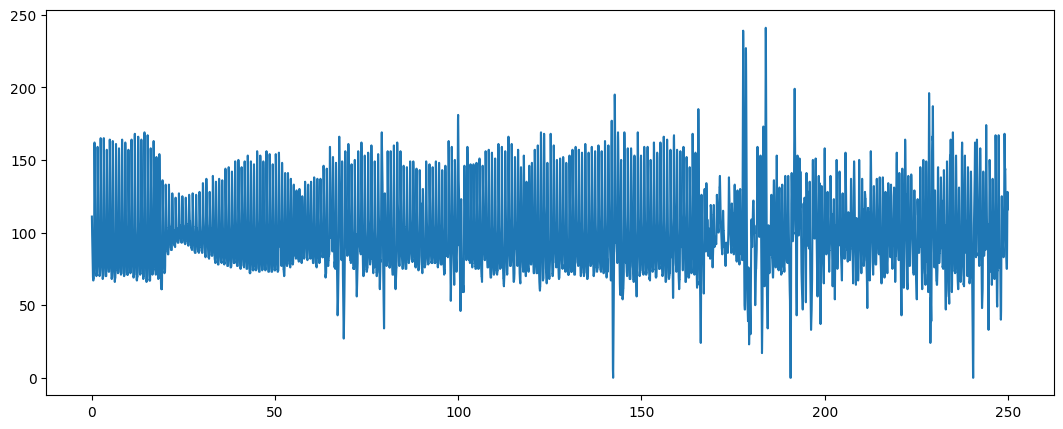

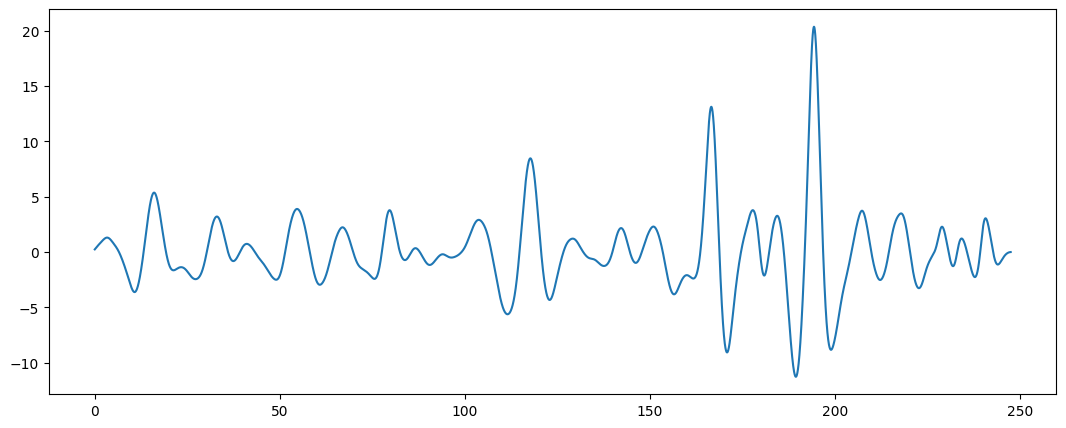

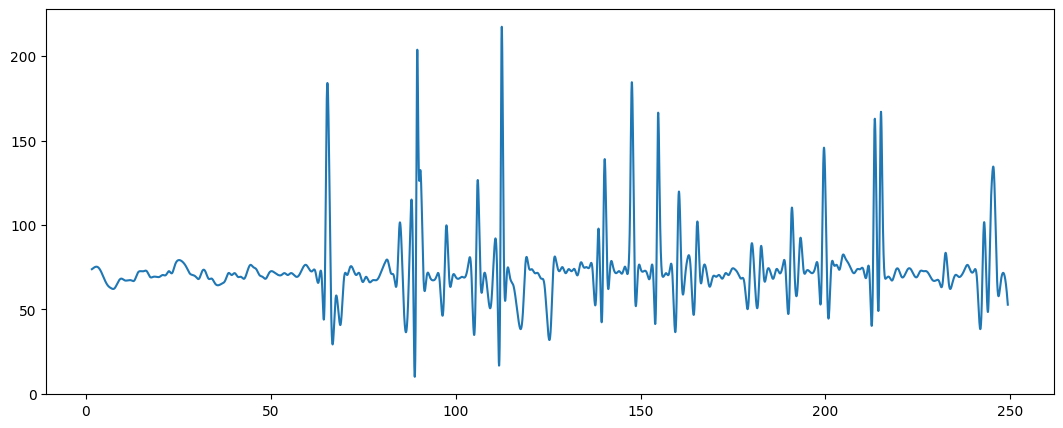

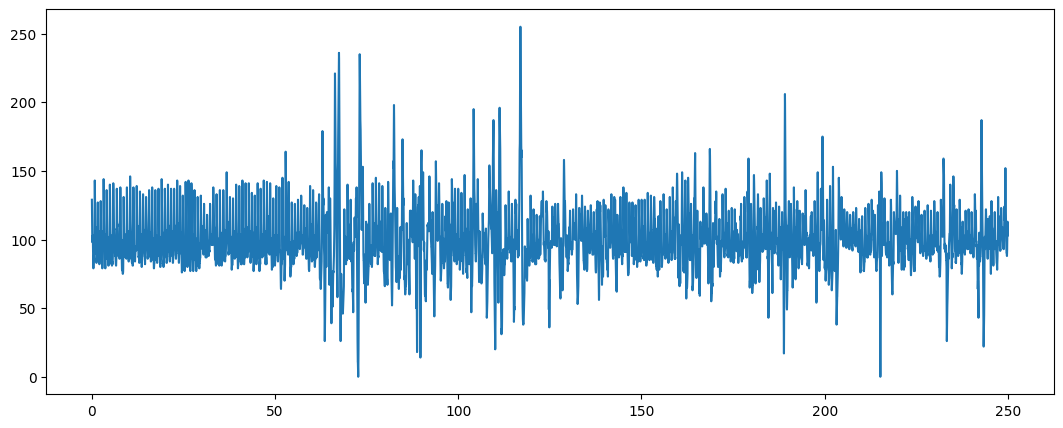

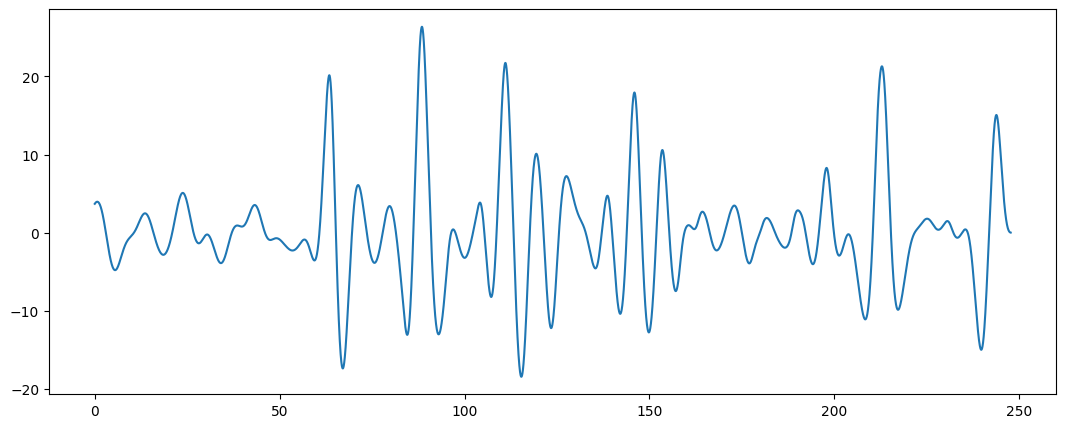

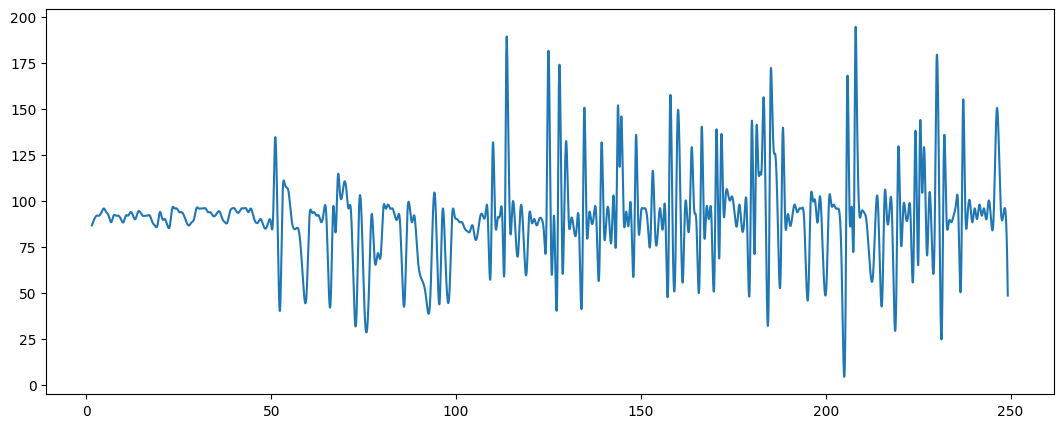

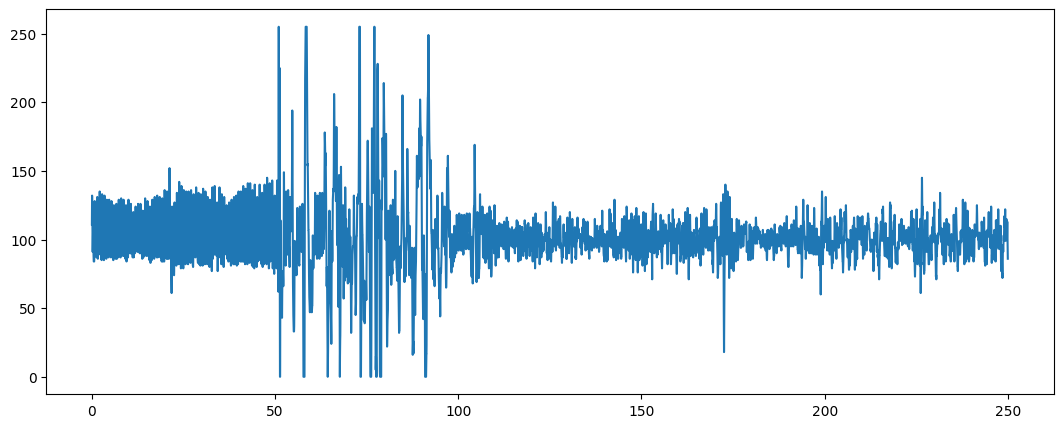

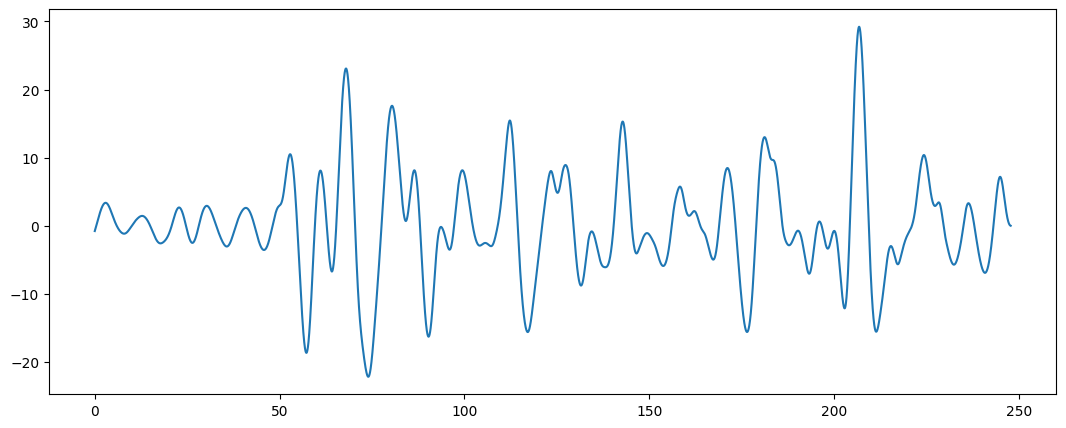

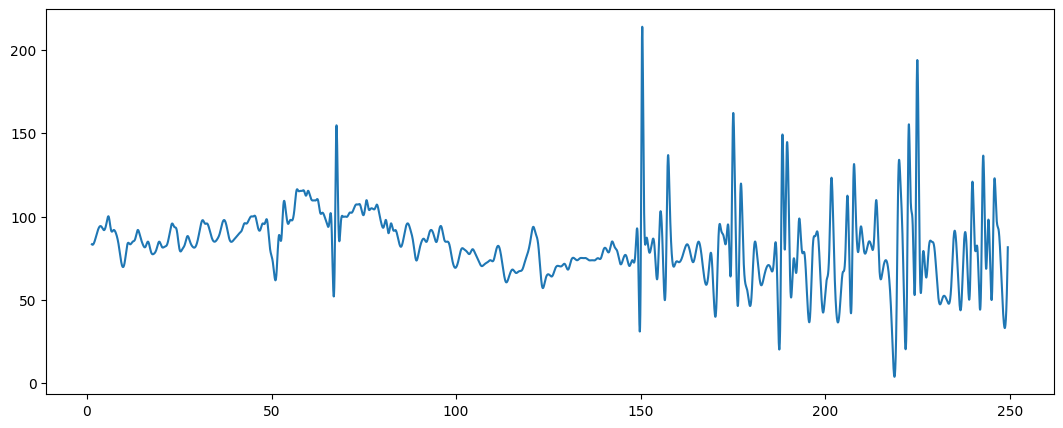

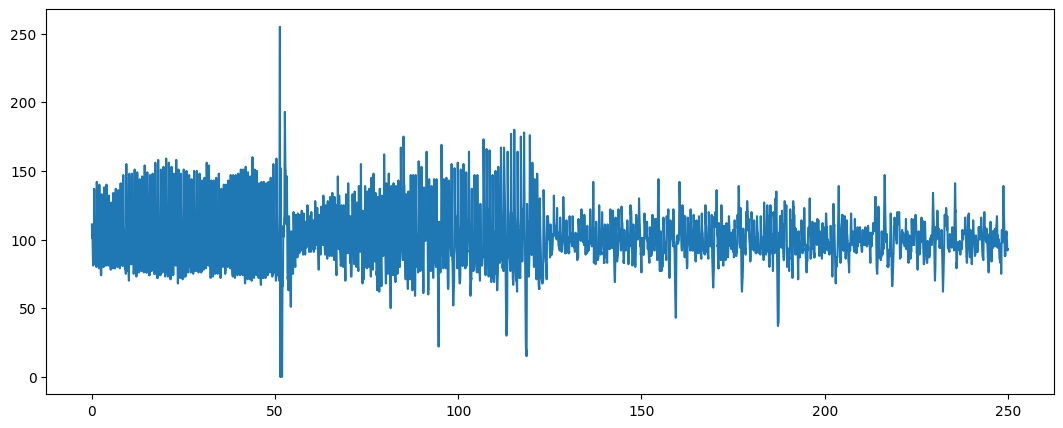

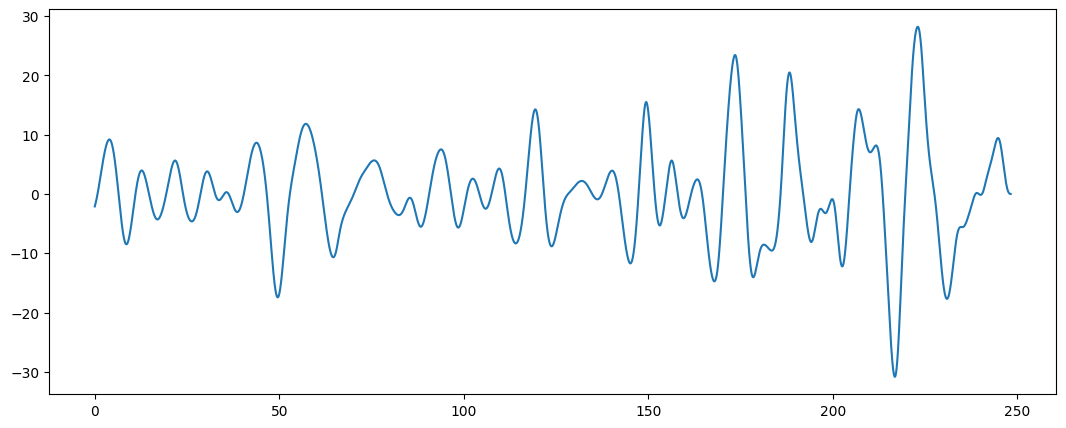

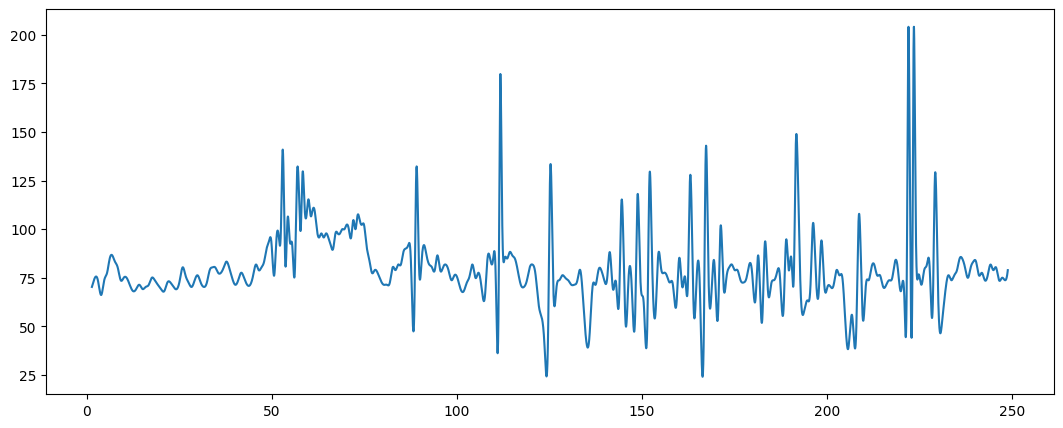

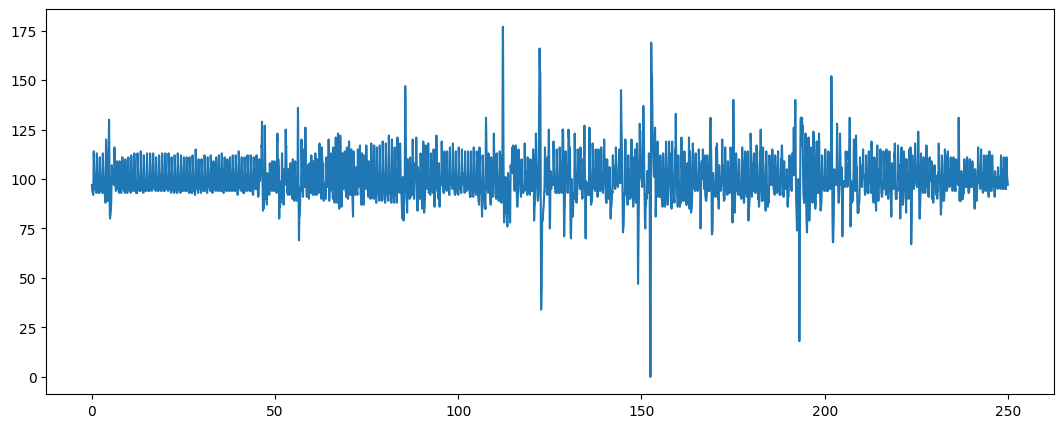

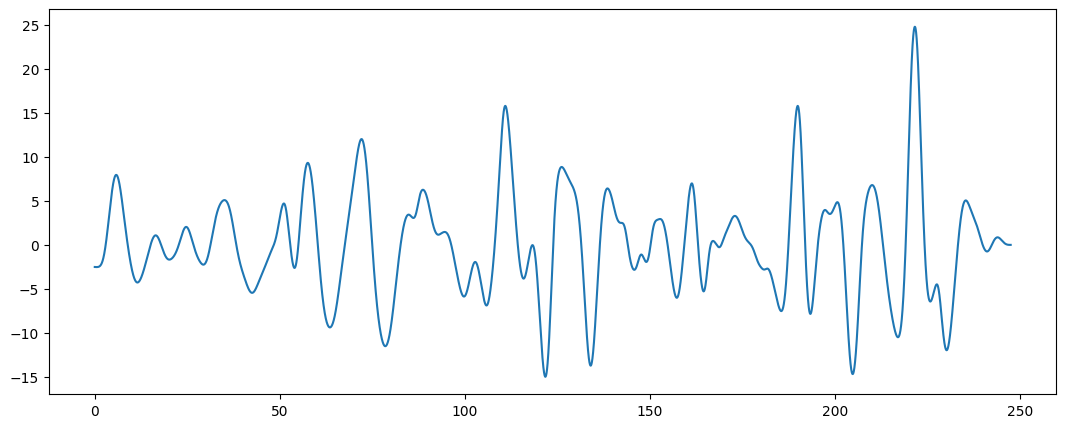

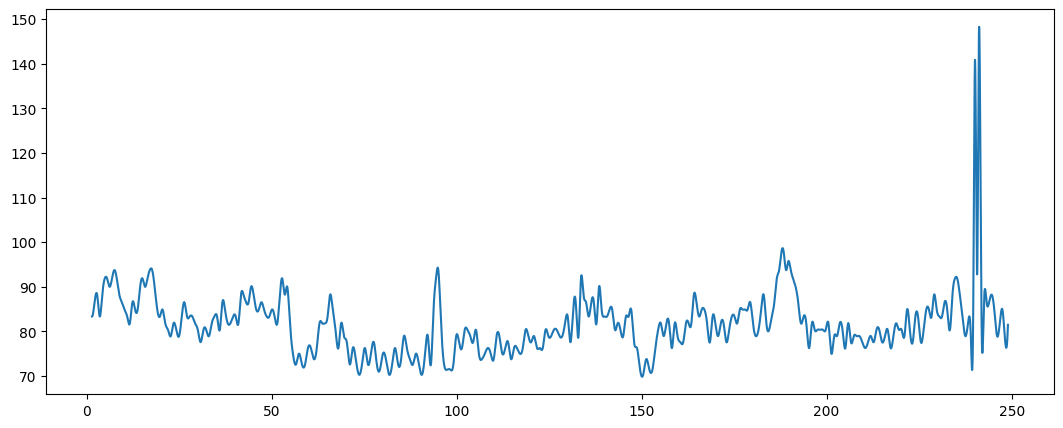

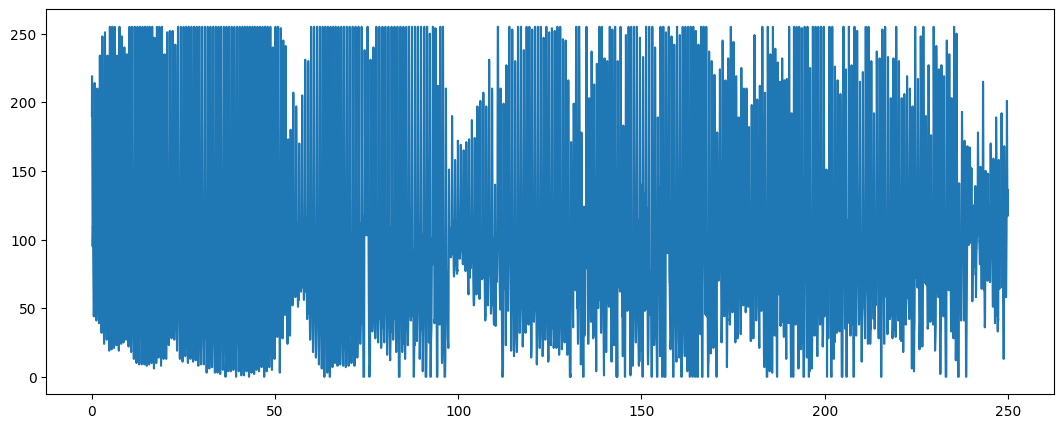

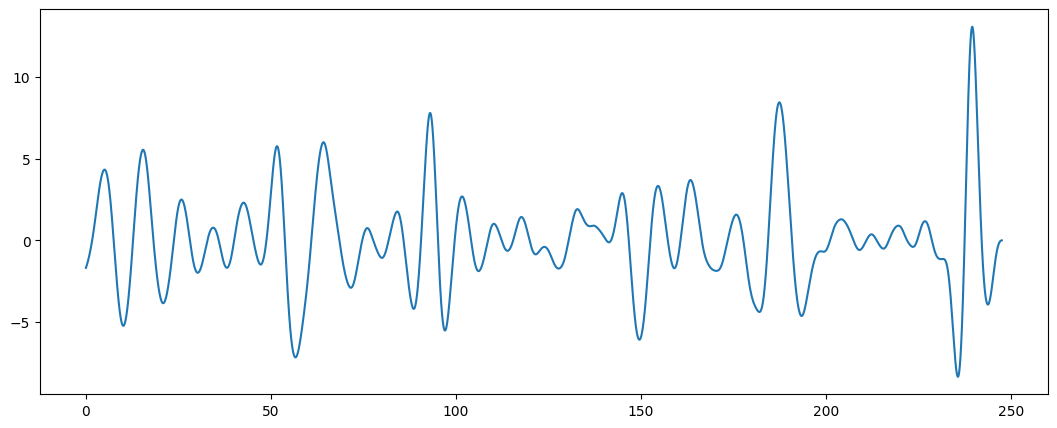

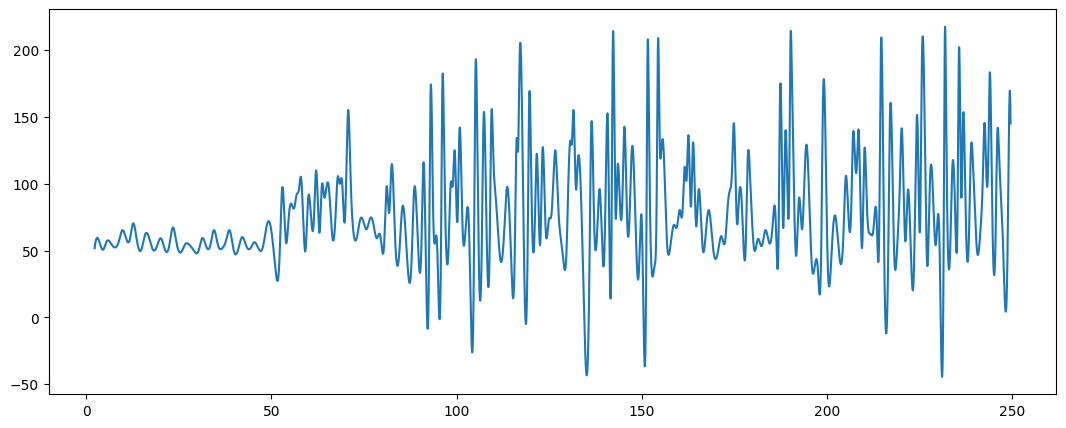

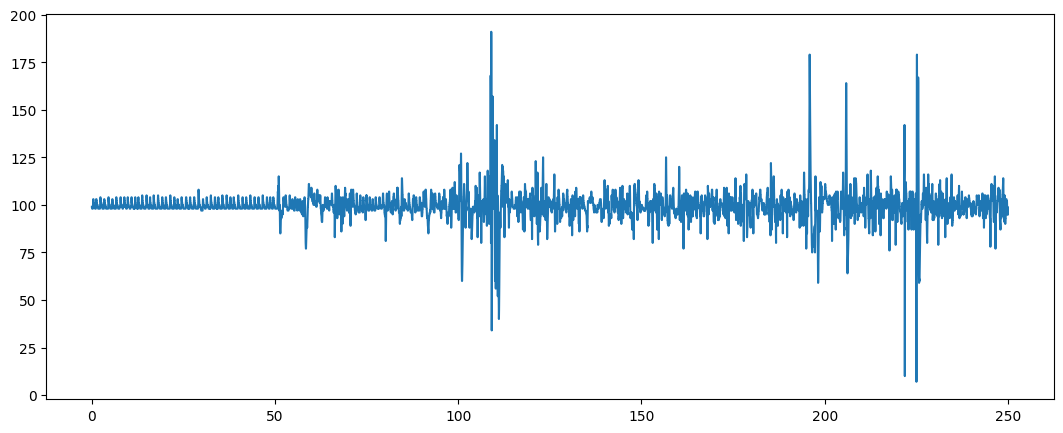

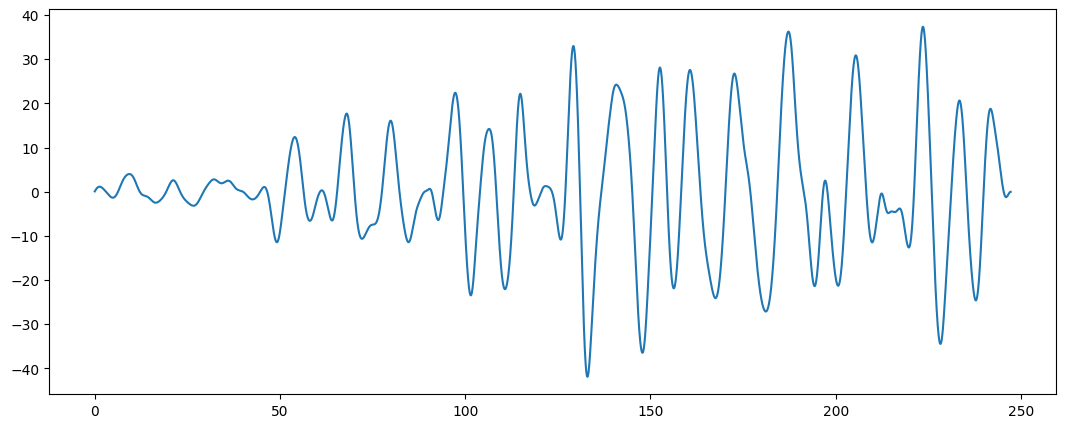

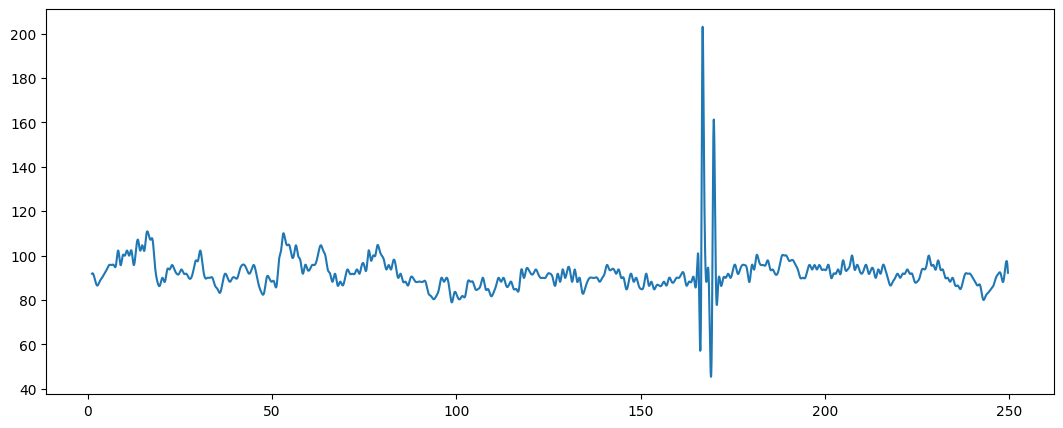

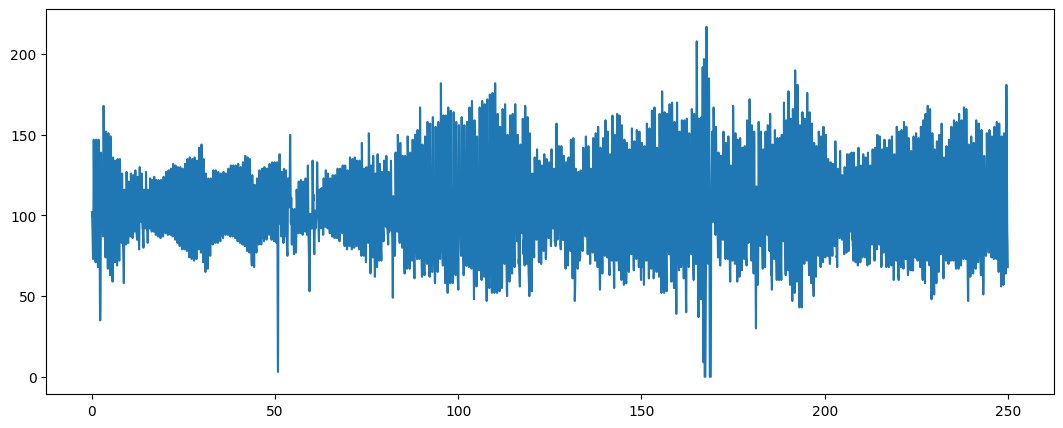

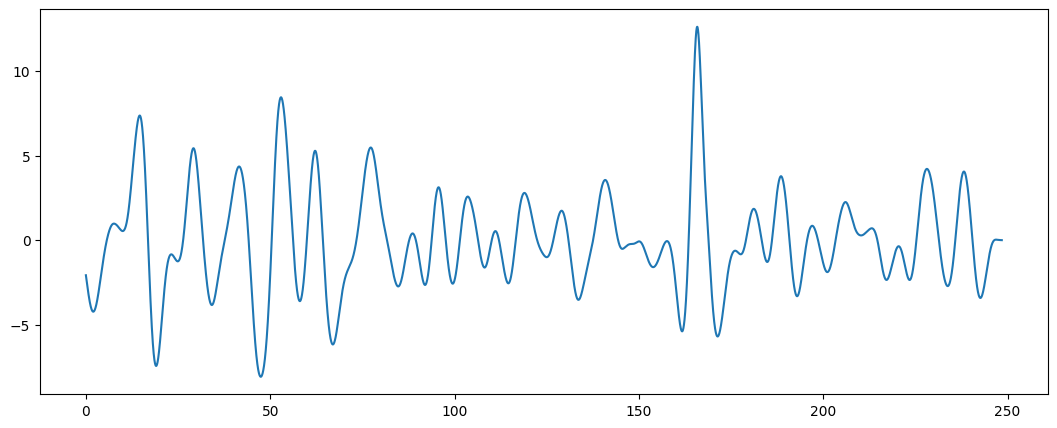

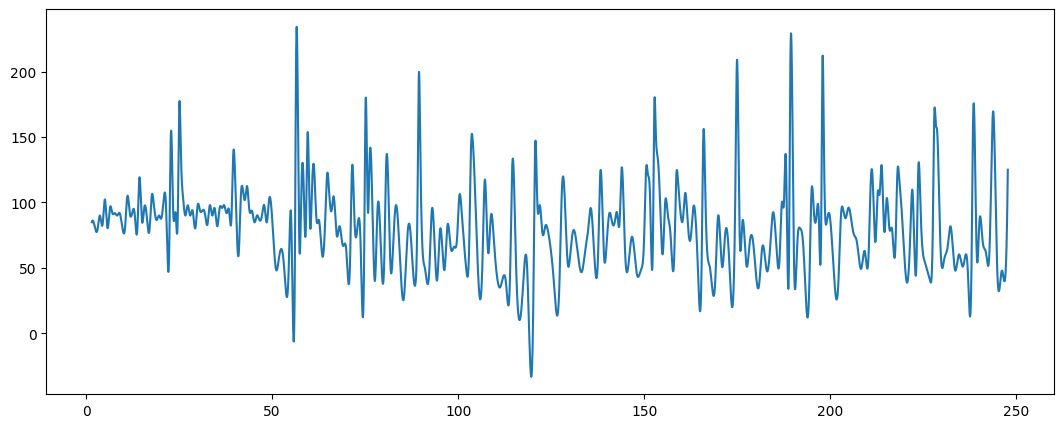

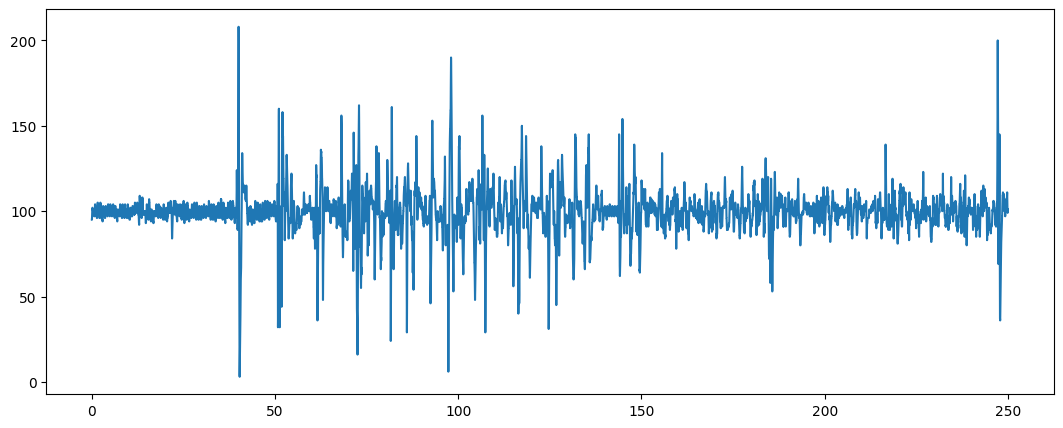

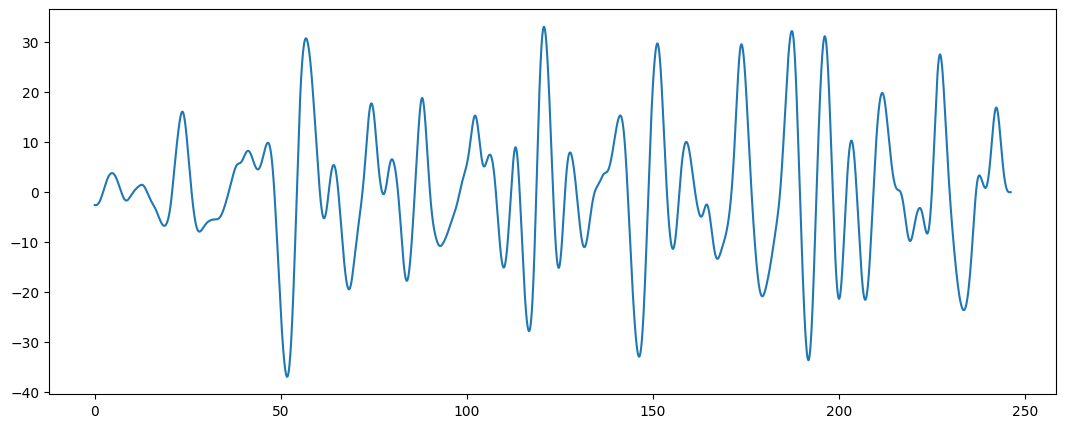

In [41]:
#event related analysis
cardiac_amplitudes_1 = [] 
cardiac_amplitudes_2 = []
cardiac_latencies_1 = []
cardiac_latencies_2 = []
for participant in participants:
    df = pd.read_csv("/Users/linaweingartner/Desktop/Bachelor/Data/LinaHorrorData/" + participant + "/experimentfull_ppg.csv")
    df.columns = ["0","PPG_Signal", "Peaks", "Threshold", "Timestamp_Seconds", "Timestamp_Unix"]
    #cutting down the time to only include the 3 minutes before the jumpscare
    timestamp_path = "/Users/linaweingartner/Desktop/Bachelor/Data/HorrorStudyData/" + participant + "/" + participant + "_jumpscareTiming.csv"
    timestamp_df = pd.read_csv(timestamp_path, header = None, dtype = 'Float64')
    if participant == "024":
        timestamp = 1700491390.476033
    else:
        timestamp = timestamp_df.iat[0,0]/1000
    df_timefiltered = df[(df["Timestamp_Unix"] > (timestamp-50))& (df["Timestamp_Unix"] < timestamp+200)]
    ppg = df_timefiltered["PPG_Signal"]
    #bk.plotting.show(sy.plot_raw(ppg, modality='ppg', sfreq=75, backend='bokeh', show_heart_rate=True))
    signal = ppg.to_numpy()
    signal, peaks = sy.ppg_peaks(signal=signal, sfreq=75, new_sfreq=75)
    #check for artefacts
    #rr = sy.input_conversion(peaks, input_type='peaks', output_type='rr_ms')
    #plot irregular values/potential artefacts
    # bk.plotting.show(
    # sy.plot_subspaces(rr, input_type='rr_ms', backend='bokeh', figsize=400)
    # )
    if participant in ["338", "333", "045", "016", "015", "010"]:
        cleanpeaks = sy.correct_peaks(peaks, input_type = "peaks")["clean_peaks"]
    elif participant in ["017", "317", "323", "337"]:
        cleanpeaks = sy.correct_peaks(peaks, input_type = "peaks", missed_correction=True, extra_correction = True)["clean_peaks"]
    elif participant in ["019", "023"]:
        cleanpeaks = sy.correct_peaks(peaks, input_type = "peaks", missed_correction = False, extra_correction = False)["clean_peaks"]
    elif participant in ["018", "024", "025", "311", "320", "342", "348", "350", "351"]:
        cleanpeaks = peaks
    heartrate, time = sy.heart_rate(cleanpeaks, 75, unit = "bpm", kind = "cubic", input_type = "peaks")
    #plot heart rate
    _, ax = plt.subplots(figsize=(13, 5))
    # for kind, color, style in zip(["cubic", "linear", "previous", "next"], 
    #                            sns.color_palette("deep", n_colors=4),
    #                            ["-", "--", ":", "-."]):
    #     hr, time = sy.heart_rate(x=peaks, input_type='peaks', kind=kind)
    #     ax.plot(time, hr, color=color, label=kind, linestyle=style)
    ax.plot(time, heartrate)
    _, ax = plt.subplots(figsize=(13, 5))
    ax.plot(time, signal)
# Show individual heartbeats
    # ax.scatter(np.where(peaks)[0][1:]/1000,
    #        np.diff(np.where(peaks)[0]),
    #        s=100, color="gray", edgecolors="k", label="Heartbeats")
    # # plt.legend()
    # ax.set_xlabel("Time (s)")
    # ax.set_ylabel("RR intervals (ms)")
    # ax.set_title("Interpolation of the instantaneous heart rate")
    # sns.despine()
    #filter heart rate to lf component
    heartrate = heartrate[~np.isnan(heartrate)]
    n = len(heartrate)
    time = time[:n]
    hr_lf = nk.signal_filter(heartrate, 75, lowcut = 0.04, highcut = 0.15, method = "butterworth")
    _, ax = plt.subplots(figsize=(13, 5))
    ax.plot(time, hr_lf)
    hrc_peaks = nk.signal_findpeaks(hr_lf)
    print(hrc_peaks)
    if participant in ["010", "015", "016", "017", "018","019", "025", "311", "317", "320", "323", "337", "342", "348", "350", "351"]:
        cardiac_amplitude_1 = hrc_peaks["Height"][0]
        cardiac_amplitude_2 = hrc_peaks["Height"][1]
        cardiac_latency_1 = hrc_peaks["Peaks"][0]
        cardiac_latency_2 = hrc_peaks["Peaks"][1]
    # elif participant == "019":
    #     cardiac_amplitude_1 = hrc_peaks["Height"][1]
    #     cardiac_amplitude_2 = hrc_peaks["Height"][2]
    #     cardiac_latency_1 = hrc_peaks["Peaks"][1]
    #     cardiac_latency_2 = hrc_peaks["Peaks"][2]
    elif participant in ["023", "024", "045", "333", "338"]:
        cardiac_amplitude_1 = hrc_peaks["Height"][0]
        cardiac_amplitude_2 = hrc_peaks["Height"][2]
        cardiac_latency_1 = hrc_peaks["Peaks"][0]
        cardiac_latency_2 = hrc_peaks["Peaks"][2]
    # elif participant == "333":
    #     cardiac_amplitude_1 = hrc_peaks["Height"][1]
    #     cardiac_amplitude_2 = hrc_peaks["Height"][3]
    #     cardiac_latency_1 = hrc_peaks["Peaks"][1]
    #     cardiac_latency_2 = hrc_peaks["Peaks"][3]
    cardiac_amplitudes_1.append(cardiac_amplitude_1) 
    cardiac_amplitudes_2.append(cardiac_amplitude_2)
    cardiac_latencies_1.append(cardiac_latency_1)
    cardiac_latencies_2.append(cardiac_latency_2)
    print(len(heartrate))
hr_header = ["ParticipantID", "Cardiac_Amp_1", "Cardiac_Lat_1", "Cardiac_Amp_2", "Cardiac_Lat_2"]
hr_df = pd.DataFrame([participants, cardiac_amplitudes_1, cardiac_latencies_1, cardiac_amplitudes_2, cardiac_latencies_2]).T
hr_df.columns = hr_header
hr_df.to_csv("/Users/linaweingartner/Desktop/Bachelor/Data/cardiac_peaks_data.csv")

In [43]:
participants = ["010", "015", "016", "017", "018","019", "025", "311", "317", "320", "323", "337", "342", "348", "350", "351"]
listoflists_bf = []
listoflists_af = []
for participant in participants:
    df = pd.read_csv("/Users/linaweingartner/Desktop/Bachelor/Data/LinaHorrorData/" + participant + "/experimentfull_ppg.csv")
    df.columns = ["0","PPG_Signal", "Peaks", "Threshold", "Timestamp_Seconds", "Timestamp_Unix"]
    #cutting down the time to only include the 3 minutes before the jumpscare
    timestamp_path = "/Users/linaweingartner/Desktop/Bachelor/Data/HorrorStudyData/" + participant + "/" + participant + "_jumpscareTiming.csv"
    timestamp_df = pd.read_csv(timestamp_path, header = None, dtype = 'Float64')
    if participant == "024":
        timestamp = 1700491390.476033
    else:
        timestamp = timestamp_df.iat[0,0]/1000
    df_before_jump = df[(df["Timestamp_Unix"] > (timestamp - 21))& (df["Timestamp_Unix"] < timestamp-1)]
    df_after_jump = df[(df["Timestamp_Unix"] > timestamp)& (df["Timestamp_Unix"] < timestamp+20)]
    ppg_bf = df_before_jump["PPG_Signal"]
    #bk.plotting.show(sy.plot_raw(ppg, modality='ppg', sfreq=75, backend='bokeh', show_heart_rate=True))
    signal_bf = ppg_bf.to_numpy()
    signal_bf, peaks_bf = sy.ppg_peaks(signal=signal_bf, sfreq=75)
    #should i resample or no?
    # Convert peaks vector to RR time series
    rr_bf = sy.input_conversion(peaks_bf, input_type='peaks', output_type='rr_ms', sfreq = 1000)
    #plot irregular values/potential artefacts
    # bk.plotting.show(
    # sy.plot_subspaces(rr, input_type='rr_ms', backend='bokeh', figsize=400)
    # ) 
    corrected_rr_bf, _ = sy.correct_rr(rr_bf)
    #bk.plotting.show(sy.plot_rr(corrected_rr, input_type='rr_ms', backend="bokeh", show_artefacts=True,line=False, figsize=300))
    hrv_time_bf = sy.time_domain(corrected_rr_bf, input_type='rr_ms').T
    values_bf = hrv_time_bf.iloc[0].to_list()
    header_bf = hrv_time_bf.iloc[1].to_list()
    string_bf = '_before_jump'
    header2 = [x + string_bf for x in header_bf]
    listoflists_bf.append(values_bf)
    ppg_af = df_after_jump["PPG_Signal"]
    #bk.plotting.show(sy.plot_raw(ppg, modality='ppg', sfreq=75, backend='bokeh', show_heart_rate=True))
    signal_af = ppg_af.to_numpy()
    signal_af, peaks_af = sy.ppg_peaks(signal=signal_af, sfreq=75)
    #should i resample or no?
    # Convert peaks vector to RR time series
    rr_af = sy.input_conversion(peaks_af, input_type='peaks', output_type='rr_ms', sfreq = 1000)
    #plot irregular values/potential artefacts
    # bk.plotting.show(
    # sy.plot_subspaces(rr, input_type='rr_ms', backend='bokeh', figsize=400)
    # ) 
    corrected_rr_af, _ = sy.correct_rr(rr_af)
    #bk.plotting.show(sy.plot_rr(corrected_rr, input_type='rr_ms', backend="bokeh", show_artefacts=True,line=False, figsize=300))
    hrv_time_af = sy.time_domain(corrected_rr_af, input_type='rr_ms').T
    values_af = hrv_time_af.iloc[0].to_list()
    header_af = hrv_time_af.iloc[1].to_list()
    string_af = '_after_jump'
    header3 = [x + string_af for x in header_af]
    listoflists_af.append(values_af)
bf_data = pd.DataFrame(listoflists_bf, columns = header2)
af_data = pd.DataFrame(listoflists_af, columns = header3)
bf_data.insert(0,"ParticipantID",participants)
af_data.insert(0,"ParticipantID",participants)
bf_data.to_csv("/Users/linaweingartner/Desktop/Bachelor/Data/heartrarte_bf.csv")
af_data.to_csv("/Users/linaweingartner/Desktop/Bachelor/Data/heartrarte_af.csv")

Cleaning the RR interval time series.
Cleaning the RR interval time series.
... correcting 3 missed interval(s).
Cleaning the RR interval time series.
Cleaning the RR interval time series.
... correcting 2 missed interval(s).
Cleaning the RR interval time series.
... correcting 1 ectopic interval(s).
Cleaning the RR interval time series.
... correcting 1 missed interval(s).
Cleaning the RR interval time series.
... correcting 1 extra interval(s).
... correcting 1 ectopic interval(s).
... correcting 1 short interval(s).
Cleaning the RR interval time series.
... correcting 1 missed interval(s).
... correcting 1 extra interval(s).
... correcting 2 ectopic interval(s).
Cleaning the RR interval time series.
Cleaning the RR interval time series.
Cleaning the RR interval time series.
Cleaning the RR interval time series.
Cleaning the RR interval time series.
Cleaning the RR interval time series.
Cleaning the RR interval time series.
Cleaning the RR interval time series.
... correcting 1 ectop

In [29]:
print(len(heartrate))

16344
